# EDA on Employee Retention - Aditya - GCD - Capstone

## Table of Content

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)<br>
3. [Exploratory Data Analysis](#section3)<br>
    a.[Examine the Data](#section301)<br>
    b.[Data pre-processing and cleaning](#section302)<br>
    c.[EDA and Inferences](#section303)<br>
4. [Feature Engineering](#section4)<br>
5. [Machine Learning Models](#section5)<br>
    a.[Build models](#section501)<br>
    b.[Declare hyper-parameters to tune the models](#section502)<br>
    c.[Fit and tune models with cross-validation](#section503)<br>
    d.[Evaluate models and finalize the model](#section504)<br>
6. [Predicting the Unknown](#section6)<br>
    a.[Format the unseen data as per our model](#section601)<br>
    b.[Run the model through the given data](#section602)<br>
    c.[Publishing the results](#section603)<br>
    

<a id = section1></a>

# 1. Problem Statement

Predict whether or not an employee would stay given the data of employees at a company.

Your client for this project is the HR Department at a software company.

    They want to try a new initiative to retain employees.
    The idea is to use data to predict whether an employee is likely to leave.
    Once these employees are identified, HR can be more proactive in reaching out to them before it's too late.
    They only want to deal with the data that is related to permanent employees.

Current Practice
Once an employee leaves, he or she is taken an interview with the name "exit interview" and shares reasons for leaving. The HR Department then tries and learns insights from the interview and makes changes accordingly.

This suffers from the following problems:

    This approach is that it's too haphazard. The quality of insight gained from an interview depends heavily on the skill of the interviewer.
    The second problem is these insights can't be aggregated and interlaced across all employees who have left.
    The third is that it is too late by the time the proposed policy changes take effect.

The HR department has hired you as data science consultants. They want to supplement their exit interviews with a more proactive approach.


### Your Role

    You are given datasets of past employees and their status (still employed or already left).
    Your task is to build a classification model using the datasets.
    Because there was no machine learning model for this problem in the company, you don’t have quantifiable win condition. 
    You need to build the best possible model.


### Problem Specifics
    Deliverable: Predict whether an employee will stay or leave.
    Machine learning task: Classification
    Target variable: Status (Employed/Left)
    Win condition: N/A (best possible model)

<a id = section2></a>

# 2. Data Description

The Business Intelligence Analysts of the Company provided you three datasets that contain information about past employees and their status (still employed or already left).

    department_data

    This dataset contains information about each department. The schema of the dataset is as follows:
        dept_id – Unique Department Code
        dept_name – Name of the Department
        dept_head – Name of the Head of the Department

    employee_details_data

    This dataset consists of Employee ID, their Age, Gender and Marital Status. The schema of this dataset is as follows:
        employee_id – Unique ID Number for each employee
        age – Age of the employee
        gender – Gender of the employee
        marital_status – Marital Status of the employee

    employee_data

    This dataset consists of each employee’s Administrative Information, Workload Information, Mutual Evaluation Information and Status.

    Target variable
        status – Current employment status (Employed / Left)

    Administrative information
        department – Department to which the employees belong(ed) to
        salary – Salary level with respect to rest of their department
        tenure – Number of years at the company
        recently_promoted – Was the employee promoted in the last 3 years?
        employee_id – Unique ID Number for each employee

    Workload information
        n_projects – Number of projects employee has worked on
        avg_monthly_hrs – Average number of hours worked per month

    Mutual evaluation information
        satisfaction – Score for employee’s satisfaction with the company (higher is better)
        last_evaluation – Score for most recent evaluation of employee (higher is better)
        filed_complaint – Has the employee filed a formal complaint in the last 3 years?


<a id = section3></a>

# 3. Exploratory Data Analysis

In [5]:
# Database 
import mysql.connector
from mysql.connector import Error
from collections import Counter

# ML
import pandas as pd
import numpy as np

# sklearn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Plotting
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

#### Data Source
Download the DataSets onto Python by connecting to the below provided MySQL instance.
                      
    host        'cpanel.insaid.co' #'projects.insaid.co'
    user 	   'student'
    passwd      'student'
    database    'Capstone2'

In [6]:
tables = ['department_data', 'employee_details_data', 'employee_data']

In [7]:
try:
    mySQLconnection = mysql.connector.connect(host='cpanel.insaid.co',#host='projects.insaid.co',
                             database='Capstone2',
                             user='student',
                             password='student')
    
    if mySQLconnection.is_connected():
        db_Info = mySQLconnection.get_server_info()
        print("Connected to MySQL database... MySQL Server version on ",db_Info)
        cursor = mySQLconnection.cursor()
        cursor.execute("select database();")
        database = cursor.fetchone()
        print ("Your connected to - ", database)
        # for table in tables:
            # cursor.execute(sql_select_Query)
            # records = cursor.fetchall()
            # print (records)
        sql_select_Query = "select * from department_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_departmentData = pd.DataFrame(SQL_Query)
        print(df_departmentData.head(3))
        
        sql_select_Query = "select * from employee_details_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_employeeDetailsData = pd.DataFrame(SQL_Query)
        print(df_employeeDetailsData.head(3))

        sql_select_Query = "select * from employee_data"
        SQL_Query = pd.read_sql_query(sql_select_Query, mySQLconnection)
        df_employeeData = pd.DataFrame(SQL_Query)
        print(df_employeeData.head(3))
except Error as e :
    print ("Error while connecting to MySQL", e)
finally:
    #closing database connection.
    if(mySQLconnection .is_connected()):
        mySQLconnection.close()
        print("MySQL connection is closed")

Connected to MySQL database... MySQL Server version on  5.6.44-cll-lve
Your connected to -  ('Capstone2',)
  dept_id dept_name        dept_head
0  D00-IT        IT       Henry Adey
1  D00-SS     Sales  Edward J Bayley
2  D00-TP      Temp  Micheal Zachrey
   employee_id  age  gender marital_status
0       113558   43    Male        Married
1       112256   24  Female      Unmarried
2       112586   22  Female      Unmarried
   avg_monthly_hrs department  filed_complaint  last_evaluation  n_projects  \
0            246.0       None              NaN         0.866838           6   
1            134.0       None              NaN         0.555718           2   
2            156.0     D00-SS              1.0         0.474082           2   

   recently_promoted  salary  satisfaction status  tenure  employee_id  
0                NaN  medium      0.134415   Left     4.0       124467  
1                NaN     low      0.511041   Left     3.0       112210  
2                NaN  medium      0.4

In [8]:
df_departmentData.to_csv('department_data_sql.csv')
df_employeeDetailsData.to_csv('employee_details_data_sql.csv')
df_employeeData.to_csv('employee_data_sql.csv')
print (df_departmentData.shape)
print (df_employeeDetailsData.shape)
print (df_employeeData.shape)

(11, 3)
(14245, 4)
(14150, 11)


<a id = section301></a>

## a. Examine the data
Now let us examine the data for general observations

In [9]:
print(df_departmentData.head(3))
print(df_departmentData.describe())

  dept_id dept_name        dept_head
0  D00-IT        IT       Henry Adey
1  D00-SS     Sales  Edward J Bayley
2  D00-TP      Temp  Micheal Zachrey
       dept_id   dept_name     dept_head
count       11          11            11
unique      11          11            11
top     D00-IT  Management  Reuben Swann
freq         1           1             1


In [10]:
print(df_employeeDetailsData.head(3))
print(df_employeeDetailsData.describe())

   employee_id  age  gender marital_status
0       113558   43    Male        Married
1       112256   24  Female      Unmarried
2       112586   22  Female      Unmarried
         employee_id           age
count   14245.000000  14245.000000
mean   112123.050544     32.889926
std      8500.457343      9.970834
min    100101.000000     22.000000
25%    105775.000000     24.000000
50%    111298.000000     29.000000
75%    116658.000000     41.000000
max    148988.000000     57.000000


In [11]:
print(df_employeeData.head(3))
print(df_employeeData.describe())

   avg_monthly_hrs department  filed_complaint  last_evaluation  n_projects  \
0            246.0       None              NaN         0.866838           6   
1            134.0       None              NaN         0.555718           2   
2            156.0     D00-SS              1.0         0.474082           2   

   recently_promoted  salary  satisfaction status  tenure  employee_id  
0                NaN  medium      0.134415   Left     4.0       124467  
1                NaN     low      0.511041   Left     3.0       112210  
2                NaN  medium      0.405101   Left     3.0       126150  
       avg_monthly_hrs  filed_complaint  last_evaluation    n_projects  \
count     14150.000000           2046.0     12663.000000  14150.000000   
mean        199.994346              1.0         0.718399      3.778304   
std          50.833697              0.0         0.173108      1.250162   
min          49.000000              1.0         0.316175      1.000000   
25%         155.00000

In [12]:
df_employeeData['employee_id'].describe()

count     14150.000000
mean     112080.750247
std        8748.202856
min           0.000000
25%      105772.500000
50%      111291.500000
75%      116650.750000
max      148988.000000
Name: employee_id, dtype: float64

Now we can see that the min employee Id is 0 that means there are such records with an invalid employee id.

In [13]:
df_employeeData[df_employeeData['employee_id']<=0]

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
34,284.0,D00-SS,NaN,0.852702,6,NaN,low,0.069168,Left,4.0,0
304,264.0,D00-ENG,NaN,0.774554,6,NaN,low,0.110974,Left,4.0,0
1234,129.0,D00-SP,NaN,0.402660,2,NaN,medium,0.437359,Left,3.0,0
11304,167.0,None,NaN,0.880053,5,NaN,low,0.682140,Employed,3.0,0
12304,259.0,D00-ENG,NaN,0.505883,5,NaN,low,0.631046,Employed,4.0,0


In [14]:
df_employeeData['avg_monthly_hrs'].describe()

count    14150.000000
mean       199.994346
std         50.833697
min         49.000000
25%        155.000000
50%        199.000000
75%        245.000000
max        310.000000
Name: avg_monthly_hrs, dtype: float64

The minimum monthly hours are 49 and max is 310 but the average is 200 and the Q1 is around 155.

In [15]:
df_departmentData['dept_id'].unique()

array(['D00-IT', 'D00-SS', 'D00-TP', 'D00-ENG', 'D00-SP', 'D00-FN',
       'D00-PR', 'D00-AD', 'D00-MN', 'D00-MT', 'D00-PD'], dtype=object)

In [16]:
df_employeeData['department'].unique()

array([None, 'D00-SS', 'D00-SP', 'D00-MT', 'D00-PD', 'D00-IT', 'D00-AD',
       'D00-MN', 'D00-ENG', 'D00-PR', 'D00-TP', 'D00-FN', '-IT'],
      dtype=object)

In [17]:
# Replace Incorrect Data -IT with proper name. This is very important to avoid invalid elements during the merge.
df_employeeData['department'].replace({'-IT': 'D00-IT'}, inplace=True)

In [18]:
df_employeeData['department'].unique()

array([None, 'D00-SS', 'D00-SP', 'D00-MT', 'D00-PD', 'D00-IT', 'D00-AD',
       'D00-MN', 'D00-ENG', 'D00-PR', 'D00-TP', 'D00-FN'], dtype=object)

In [19]:
df_employeeDetailsData['age'].isna().unique()

array([False])

In [20]:
df_empData = pd.merge(df_employeeData, df_employeeDetailsData, how='left', on="employee_id")

In [21]:
print (df_empData.head())
print (df_empData.shape)

   avg_monthly_hrs department  filed_complaint  last_evaluation  n_projects  \
0            246.0       None              NaN         0.866838           6   
1            134.0       None              NaN         0.555718           2   
2            156.0     D00-SS              1.0         0.474082           2   
3            256.0     D00-SP              NaN         0.961360           6   
4            146.0     D00-SS              NaN         0.507349           2   

   recently_promoted  salary  satisfaction status  tenure  employee_id   age  \
0                NaN  medium      0.134415   Left     4.0       124467  42.0   
1                NaN     low      0.511041   Left     3.0       112210  23.0   
2                NaN  medium      0.405101   Left     3.0       126150  24.0   
3                NaN     low      0.152974   Left     4.0       125346  51.0   
4                NaN  medium      0.434845   Left     3.0       113707  23.0   

   gender marital_status  
0  Female        

In [22]:
df_empData['age'].isna().unique()

array([False,  True])

In [23]:
df = pd.merge(df_empData, df_departmentData, how='left', left_on='department', right_on='dept_id')
#df = df_empData.copy()

In [24]:
print (df.head())
print (df.shape)

   avg_monthly_hrs department  filed_complaint  last_evaluation  n_projects  \
0            246.0       None              NaN         0.866838           6   
1            134.0       None              NaN         0.555718           2   
2            156.0     D00-SS              1.0         0.474082           2   
3            256.0     D00-SP              NaN         0.961360           6   
4            146.0     D00-SS              NaN         0.507349           2   

   recently_promoted  salary  satisfaction status  tenure  employee_id   age  \
0                NaN  medium      0.134415   Left     4.0       124467  42.0   
1                NaN     low      0.511041   Left     3.0       112210  23.0   
2                NaN  medium      0.405101   Left     3.0       126150  24.0   
3                NaN     low      0.152974   Left     4.0       125346  51.0   
4                NaN  medium      0.434845   Left     3.0       113707  23.0   

   gender marital_status dept_id dept_name  

In [25]:
df = df.drop('department', 1)

In [26]:
df.to_csv('Employee_original_data.csv')
print (df.head())
print (df.shape)

   avg_monthly_hrs  filed_complaint  last_evaluation  n_projects  \
0            246.0              NaN         0.866838           6   
1            134.0              NaN         0.555718           2   
2            156.0              1.0         0.474082           2   
3            256.0              NaN         0.961360           6   
4            146.0              NaN         0.507349           2   

   recently_promoted  salary  satisfaction status  tenure  employee_id   age  \
0                NaN  medium      0.134415   Left     4.0       124467  42.0   
1                NaN     low      0.511041   Left     3.0       112210  23.0   
2                NaN  medium      0.405101   Left     3.0       126150  24.0   
3                NaN     low      0.152974   Left     4.0       125346  51.0   
4                NaN  medium      0.434845   Left     3.0       113707  23.0   

   gender marital_status dept_id dept_name        dept_head  
0  Female        Married     NaN       NaN      

<a id = section302></a>

## b. Data pre-processing and cleaning

In [27]:
df.columns

Index(['avg_monthly_hrs', 'filed_complaint', 'last_evaluation', 'n_projects',
       'recently_promoted', 'salary', 'satisfaction', 'status', 'tenure',
       'employee_id', 'age', 'gender', 'marital_status', 'dept_id',
       'dept_name', 'dept_head'],
      dtype='object')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14150 entries, 0 to 14149
Data columns (total 16 columns):
avg_monthly_hrs      14150 non-null float64
filed_complaint      2046 non-null float64
last_evaluation      12663 non-null float64
n_projects           14150 non-null int64
recently_promoted    297 non-null float64
salary               14150 non-null object
satisfaction         14000 non-null float64
status               14150 non-null object
tenure               14000 non-null float64
employee_id          14150 non-null int64
age                  14145 non-null float64
gender               14145 non-null object
marital_status       14145 non-null object
dept_id              13443 non-null object
dept_name            13443 non-null object
dept_head            13443 non-null object
dtypes: float64(7), int64(2), object(7)
memory usage: 1.8+ MB


In [29]:
df.describe(include='all')

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id,age,gender,marital_status,dept_id,dept_name,dept_head
count,14150.000000,2046.0,12663.000000,14150.000000,297.0,14150,14000.000000,14150,14000.000000,14150.000000,14145.000000,14145,14145,13443,13443,13443
unique,NaN,NaN,NaN,NaN,NaN,3,NaN,2,NaN,NaN,NaN,2,2,11,11,11
top,NaN,NaN,NaN,NaN,NaN,low,NaN,Employed,NaN,NaN,NaN,Male,Unmarried,D00-SS,Sales,Edward J Bayley
freq,NaN,NaN,NaN,NaN,NaN,6906,NaN,10784,NaN,NaN,NaN,9304,7226,3905,3905,3905
mean,199.994346,1.0,0.718399,3.778304,1.0,NaN,0.621212,NaN,3.499357,112080.750247,32.898621,NaN,NaN,NaN,NaN,NaN
std,50.833697,0.0,0.173108,1.250162,0.0,NaN,0.250482,NaN,1.462584,8748.202856,9.978939,NaN,NaN,NaN,NaN,NaN
min,49.000000,1.0,0.316175,1.000000,1.0,NaN,0.040058,NaN,2.000000,0.000000,22.000000,NaN,NaN,NaN,NaN,NaN
25%,155.000000,1.0,0.563711,3.000000,1.0,NaN,0.450356,NaN,3.000000,105772.500000,24.000000,NaN,NaN,NaN,NaN,NaN
50%,199.000000,1.0,0.724731,4.000000,1.0,NaN,0.652394,NaN,3.000000,111291.500000,29.000000,NaN,NaN,NaN,NaN,NaN
75%,245.000000,1.0,0.871409,5.000000,1.0,NaN,0.824925,NaN,4.000000,116650.750000,41.000000,NaN,NaN,NaN,NaN,NaN


In [30]:
df.isnull().sum()[df.isnull().sum() !=0]

filed_complaint      12104
last_evaluation       1487
recently_promoted    13853
satisfaction           150
tenure                 150
age                      5
gender                   5
marital_status           5
dept_id                707
dept_name              707
dept_head              707
dtype: int64

In [31]:
df.shape

(14150, 16)

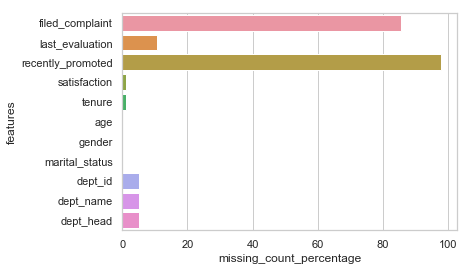

In [32]:
missing = df.isnull().sum()[df.isnull().sum() !=0]
missing = pd.DataFrame(missing.reset_index())
missing.rename(columns={'index':'features',0:'missing_count'}, inplace = True)
missing['missing_count_percentage'] = ((missing['missing_count'])/df.shape[0])*100
plt.figure()
sns.barplot(y = missing['features'], x = missing['missing_count_percentage'])

In [33]:
# Drop the two columns with large number of missing elements
df.drop(['filed_complaint','recently_promoted'], axis=1, inplace = True)

In [34]:
# Drop records with missing elements
df.dropna(subset=['age', 'gender', 'marital_status', 'dept_id', 'dept_name', 'dept_head'], inplace = True)

#### Impute the missing values - Analyze the outliers to choose either Median or Mean

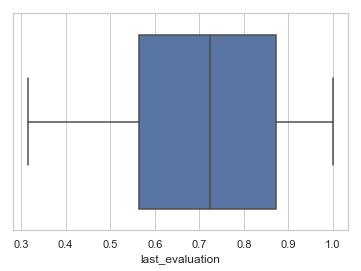

In [35]:
plt.plot(figsize=(15,10))
sns.boxplot(df['last_evaluation'])

In [36]:
# last_evaluation has no outliers - Mean should do the job here
df['last_evaluation'].fillna(df['last_evaluation'].mean(),inplace=True)

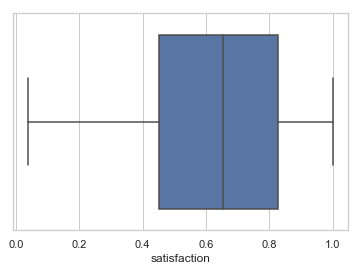

In [37]:
plt.plot(figsize=(15,10))
sns.boxplot(df['satisfaction'])

In [38]:
# satisfaction has no outliers - Mean should do the job here
df['satisfaction'].fillna(df['satisfaction'].mean(),inplace=True)

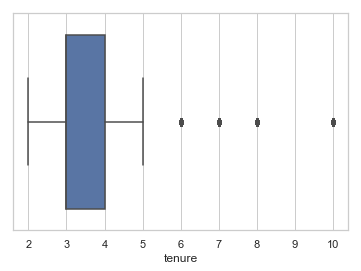

In [39]:
plt.plot(figsize=(15,10))
sns.boxplot(df['tenure'])

In [40]:
# tenure has outliers - Median should do the job here
df['tenure'].fillna(df['tenure'].median(),inplace=True)

In [41]:
df.isnull().sum()[df.isnull().sum() !=0]

Series([], dtype: int64)

In [42]:
df[df['employee_id']<=0]

,avg_monthly_hrs,last_evaluation,n_projects,salary,satisfaction,status,tenure,employee_id,age,gender,marital_status,dept_id,dept_name,dept_head


In [43]:
# Drop Records with Invalid Employee ID
df = df[df['employee_id']>0]

In [44]:
# Check for duplicates
df[df.duplicated()].count()

avg_monthly_hrs    29
last_evaluation    29
n_projects         29
salary             29
satisfaction       29
status             29
tenure             29
employee_id        29
age                29
gender             29
marital_status     29
dept_id            29
dept_name          29
dept_head          29
dtype: int64

In [45]:
# Drop Duplicates
df.drop_duplicates(inplace = True) 

### Addressing Challenges 

    1. Few records in the employee dataset have incorrect department values "-IT"
        a. Get the correct department value from the Department data set and update the employee records with the correct department value D00-IT 	
										
    2. Following fields from the employee data set have missing values:
        recently_promoted    97.90 %
        filed_complaint      85.54%
        last_evaluation      10.51%
        department            5.00%
        tenure                1.06%
        satisfaction          1.06%"			
        a. Drop the columns/fields with high number of missing values i.e.recently_promoted and filed_complaint.
        b. Delete the records with missing /null values of department since the percentages of records with these missing values are very less.
        c. We have visualize the box plot for last_evaluation and satisfaction columns, value ranges between 0 and 1. Missing records present is 1.06%. We have replaced the same with the mean value.
        d. Similarly we have visualize the box plot for tenure column and found outliers, value ranges between 2 and 10. Missing records present is 1.06%. We have replaced the same with the median value because we need integer not float.
					
    3. Employee personal details i.e. age , gender, marital_status and department details i.e. name and dept head details are in separate data sets.			
        a. Perform a left merge/join to get all the personal details as well as the department details into a single dataframe. This gives a complete employee data set.	
									
    4. Few records (5 records) in the employee data set are present with 0 as the employee ID.			
        a. Delete the invalid records	
				
    5. There are few duplicate records (29 records) with the same empoyee id and employee details in the employee dataset.			a. Delete the duplicate records.	
					
    6. The final employee dataset has the following columns:
        a. avg monthly hrs   
        b. department (replace dept id with the dept name)     
        c. last evaluation    
        d. no of projects        
        e. salary            
        f. satisfaction       
        g. status (target variable)
        h. tenure
        i. age               
        j. gender            
        k. marital status 

    7. Outliers : There are no outliers			
        a. No action needs to be taken 	

    8. Following are the categorical features :
        department, salary, status, gender, marital_status	
        a. Use label encoding to change the following categorical features to a numerical format:
            salary (low-1, medium-2, high-0). Here , salary is an ordinal feature
            status (left-1, employed-0)
            gender (male-1, female-0)
            marital status(married-0,unmarried-1)
        b. Apply get_dummies on the department feature and get the employee updated dataset with 20 features."	
									
    9. Following are the numerical features:
        average monthly hrs, last evaluation,no of projects , tenure, age
        a. Apply scaling process to the following features to bring them to the same range:
            average monthly hrs, no of projects, tenure and age"				

<a id = section303></a>

## c. EDA and Inferences

In [46]:
CATEGORICAL_COLUMNS = ["gender", "marital_status", "salary", "status"]

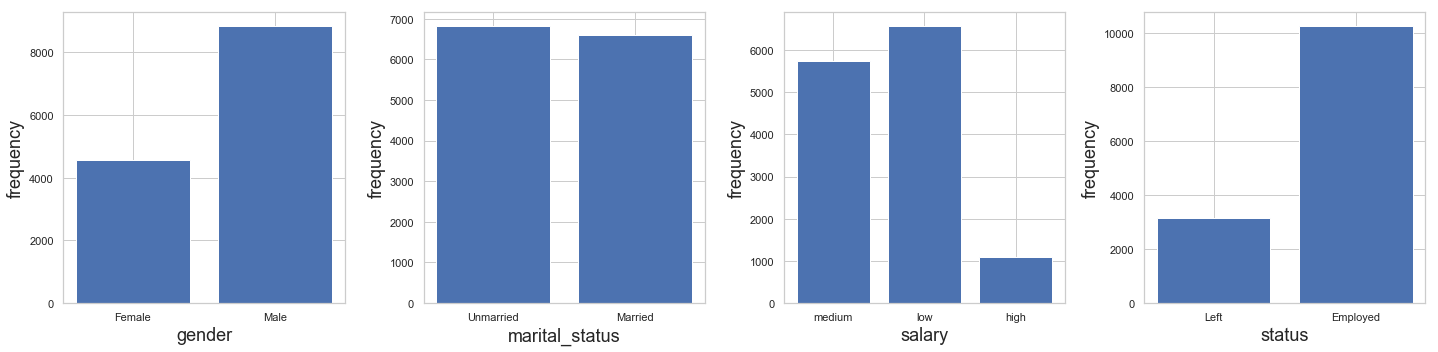

In [47]:
def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(df[CATEGORICAL_COLUMNS])

In [48]:
CONTINUOUS_COLUMNS = ["age", "avg_monthly_hrs", "last_evaluation", "n_projects", "satisfaction", "tenure"]

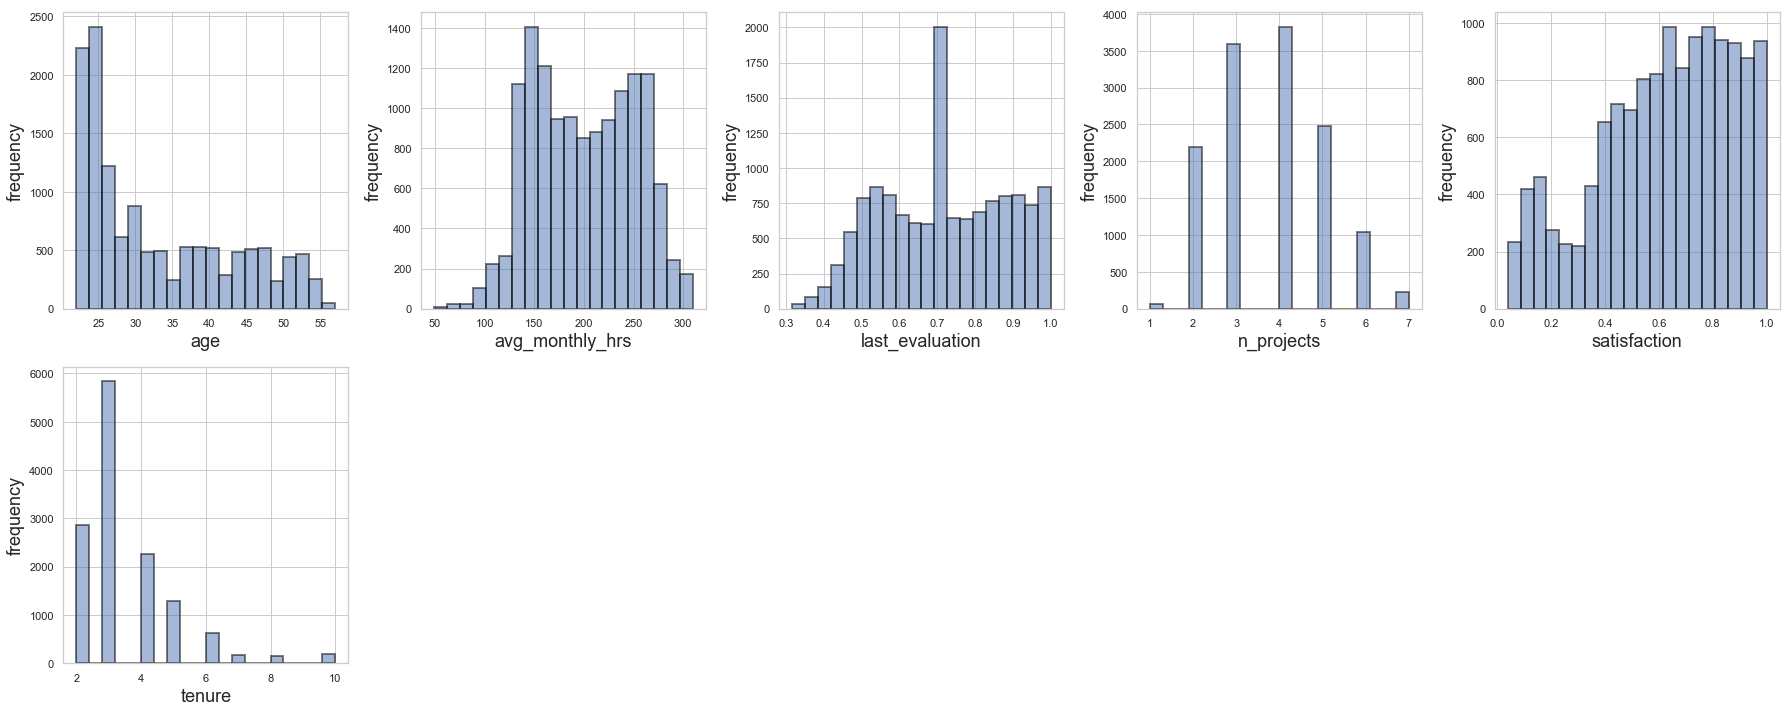

In [49]:
def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histgrams(df[CONTINUOUS_COLUMNS])

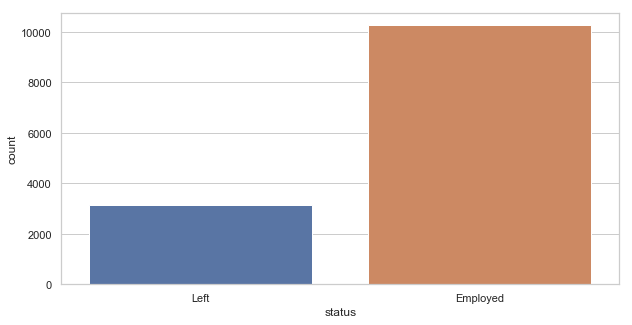

In [50]:
axis1 = plt.subplots(1,1,figsize=(10,5))
sns.countplot(x='status',data=df)

Employed    10260
Left         3150
Name: status, dtype: int64


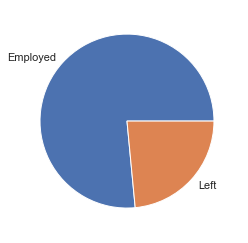

In [51]:
# Getting the count of people
leftcounts=df['status'].value_counts()
print(leftcounts)

# Using matplotlib pie chart and label the pie chart
plt.pie(leftcounts,labels=['Employed','Left']);

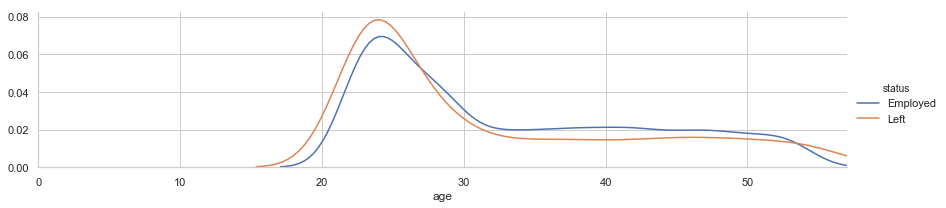

In [52]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'age')
facet.set(xlim=(0, df['age'].max()))
facet.add_legend()

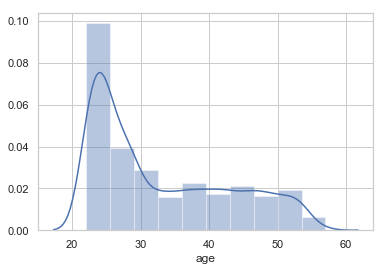

In [53]:
sns.distplot(df["age"],bins=10,kde=True)

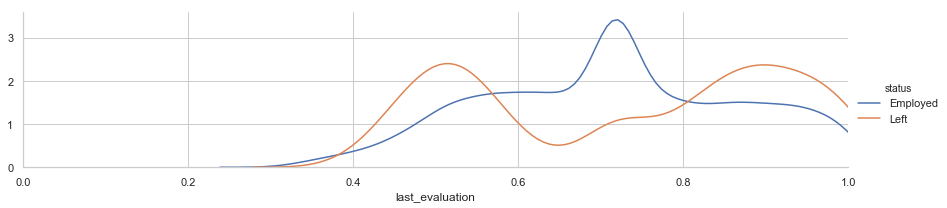

In [54]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'last_evaluation')
facet.set(xlim=(0, df['last_evaluation'].max()))
facet.add_legend()

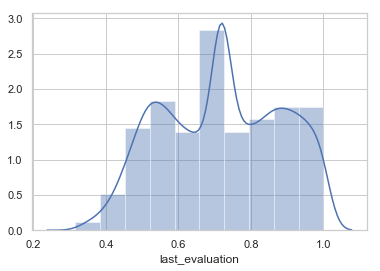

In [55]:
sns.distplot(df["last_evaluation"],bins=10,kde=True)

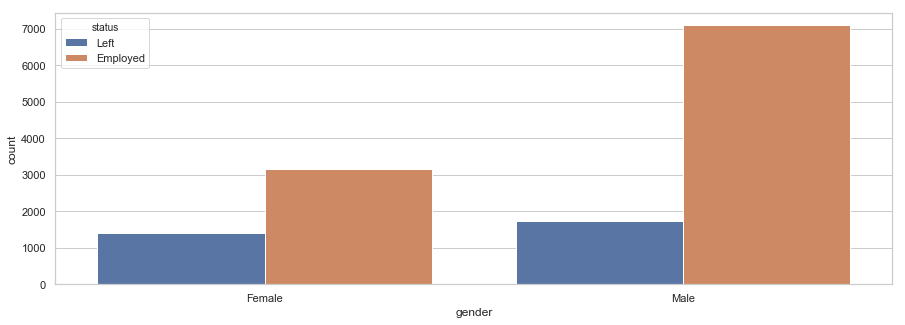

In [56]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='gender', hue="status", data=df, ax=axis1)

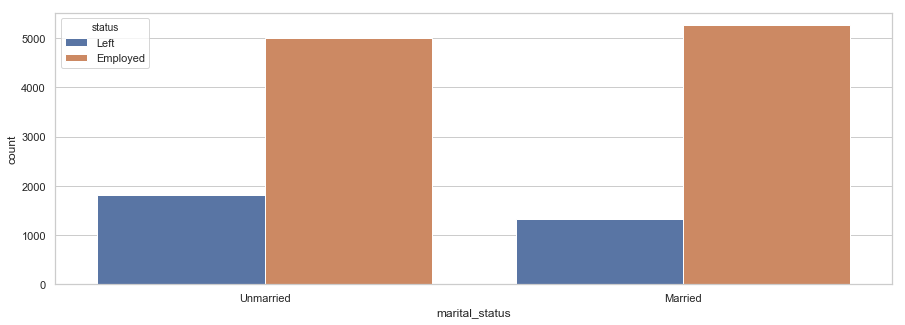

In [57]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='marital_status', hue="status", data=df, ax=axis1)

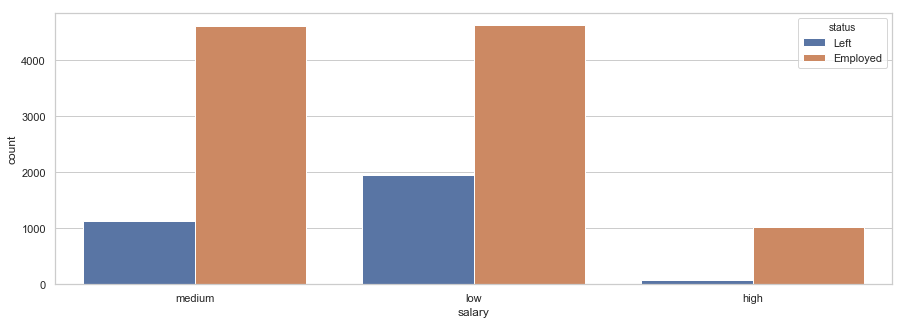

In [58]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='salary', hue="status", data=df, ax=axis1)

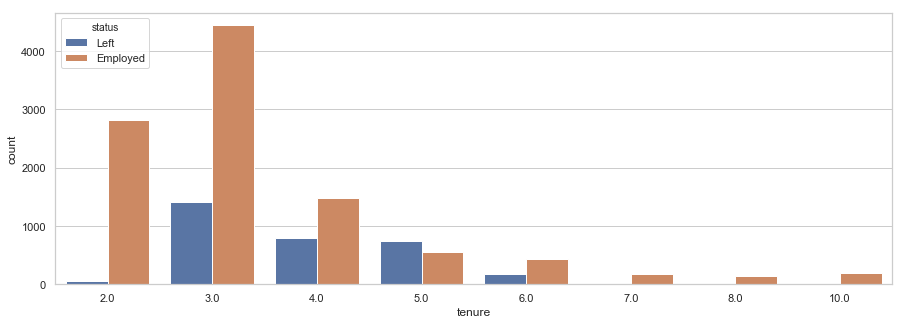

In [59]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='tenure', hue="status", data=df, ax=axis1)

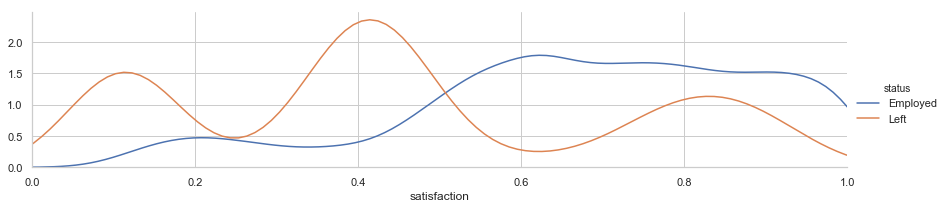

In [60]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'satisfaction')
facet.set(xlim=(0, df['satisfaction'].max()))
facet.add_legend()

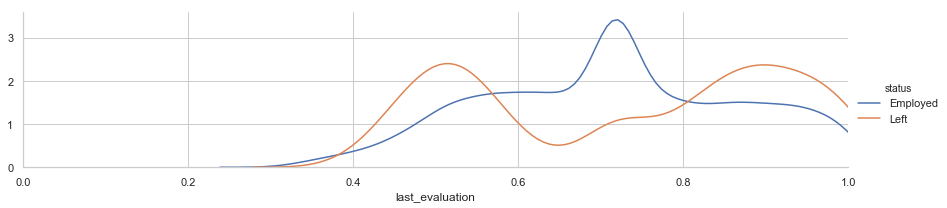

In [61]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'last_evaluation')
facet.set(xlim=(0, df['last_evaluation'].max()))
facet.add_legend()

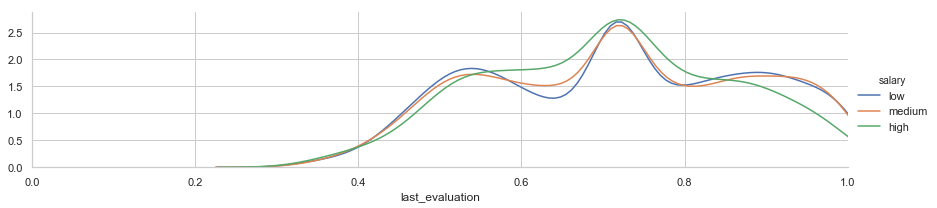

In [62]:
facet = sns.FacetGrid(df, hue="salary",aspect=4, hue_order=['low', 'medium', 'high'])
facet.map(sns.kdeplot,'last_evaluation')
facet.set(xlim=(0, df['last_evaluation'].max()))
facet.add_legend()

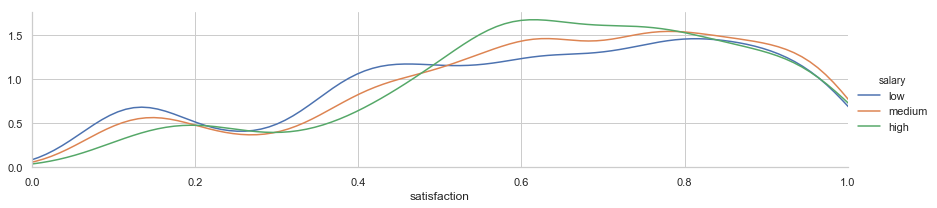

In [63]:
facet = sns.FacetGrid(df, hue="salary",aspect=4, hue_order=['low', 'medium', 'high'])
facet.map(sns.kdeplot,'satisfaction')
facet.set(xlim=(0, df['satisfaction'].max()))
facet.add_legend()

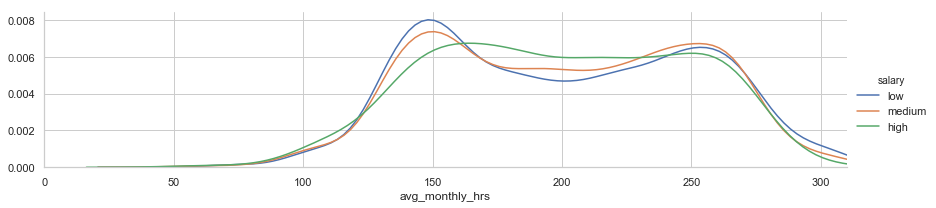

In [64]:
facet = sns.FacetGrid(df, hue="salary",aspect=4, hue_order=['low', 'medium', 'high'])
facet.map(sns.kdeplot,'avg_monthly_hrs')
facet.set(xlim=(0, df['avg_monthly_hrs'].max()))
facet.add_legend()

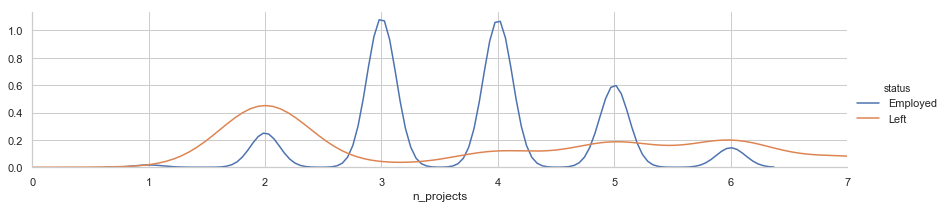

In [65]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'n_projects')
facet.set(xlim=(0, df['n_projects'].max()))
facet.add_legend()

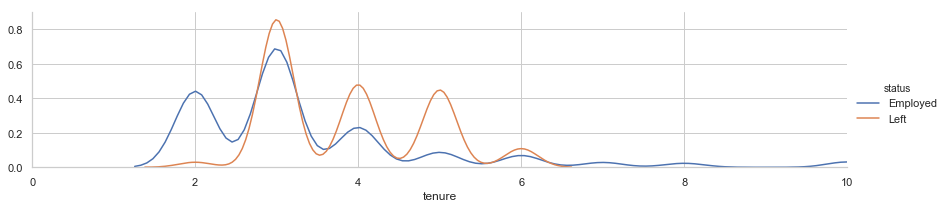

In [66]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'tenure')
facet.set(xlim=(0, df['tenure'].max()))
facet.add_legend()

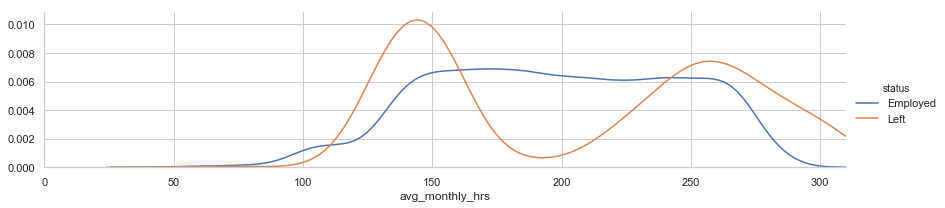

In [67]:
facet = sns.FacetGrid(df, hue="status",aspect=4, hue_order=['Employed', 'Left'])
facet.map(sns.kdeplot,'avg_monthly_hrs')
facet.set(xlim=(0, df['avg_monthly_hrs'].max()))
facet.add_legend()

In [68]:
left_df = df[(df['status'] == 'Left')]
employed_df = df[(df['status'] != 'Left')]

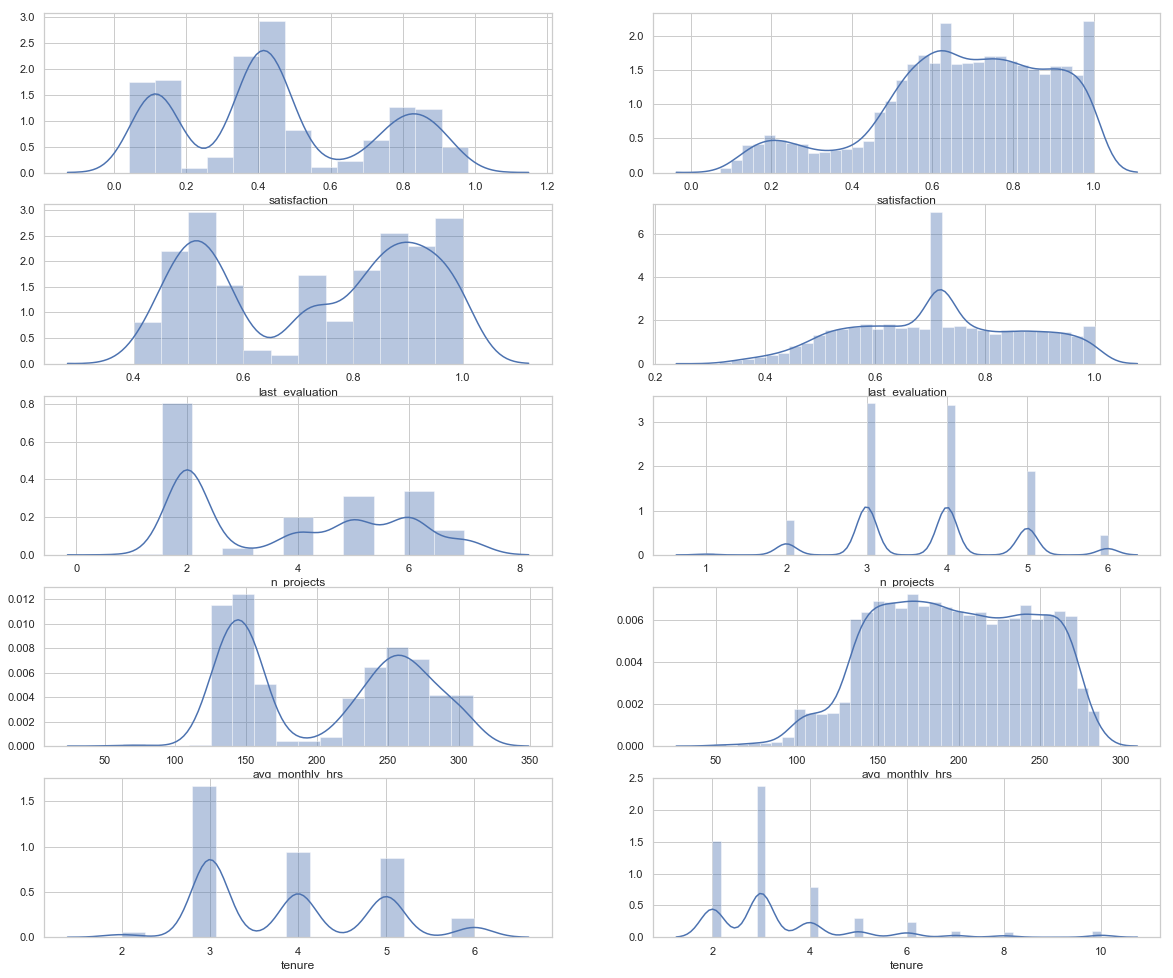

In [69]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(20,17))
ax1 = fig.add_subplot(521)
ax2 = fig.add_subplot(522)
ax3 = fig.add_subplot(523)
ax4 = fig.add_subplot(524)
ax5 = fig.add_subplot(525)
ax6 = fig.add_subplot(526)
ax7 = fig.add_subplot(527)
ax8 = fig.add_subplot(528)
ax9 = fig.add_subplot(529)
ax10 = fig.add_subplot(5,2,10)# Tell pointplot to plot on ax1 with the ax argument (satisfaction level)
sns.distplot(left_df['satisfaction'],ax = ax1);
sns.distplot(employed_df['satisfaction'],ax = ax2);
sns.distplot(left_df['last_evaluation'], kde=True,ax=ax3);
sns.distplot(employed_df['last_evaluation'], kde=True,ax=ax4);
sns.distplot(left_df['n_projects'], kde=True,ax=ax5);
sns.distplot(employed_df['n_projects'], kde=True,ax=ax6);
sns.distplot(left_df['avg_monthly_hrs'], kde=True,ax=ax7);
sns.distplot(employed_df['avg_monthly_hrs'], kde=True,ax=ax8);
sns.distplot(left_df['tenure'], kde=True,ax=ax9);
sns.distplot(employed_df['tenure'], kde=True,ax=ax10);

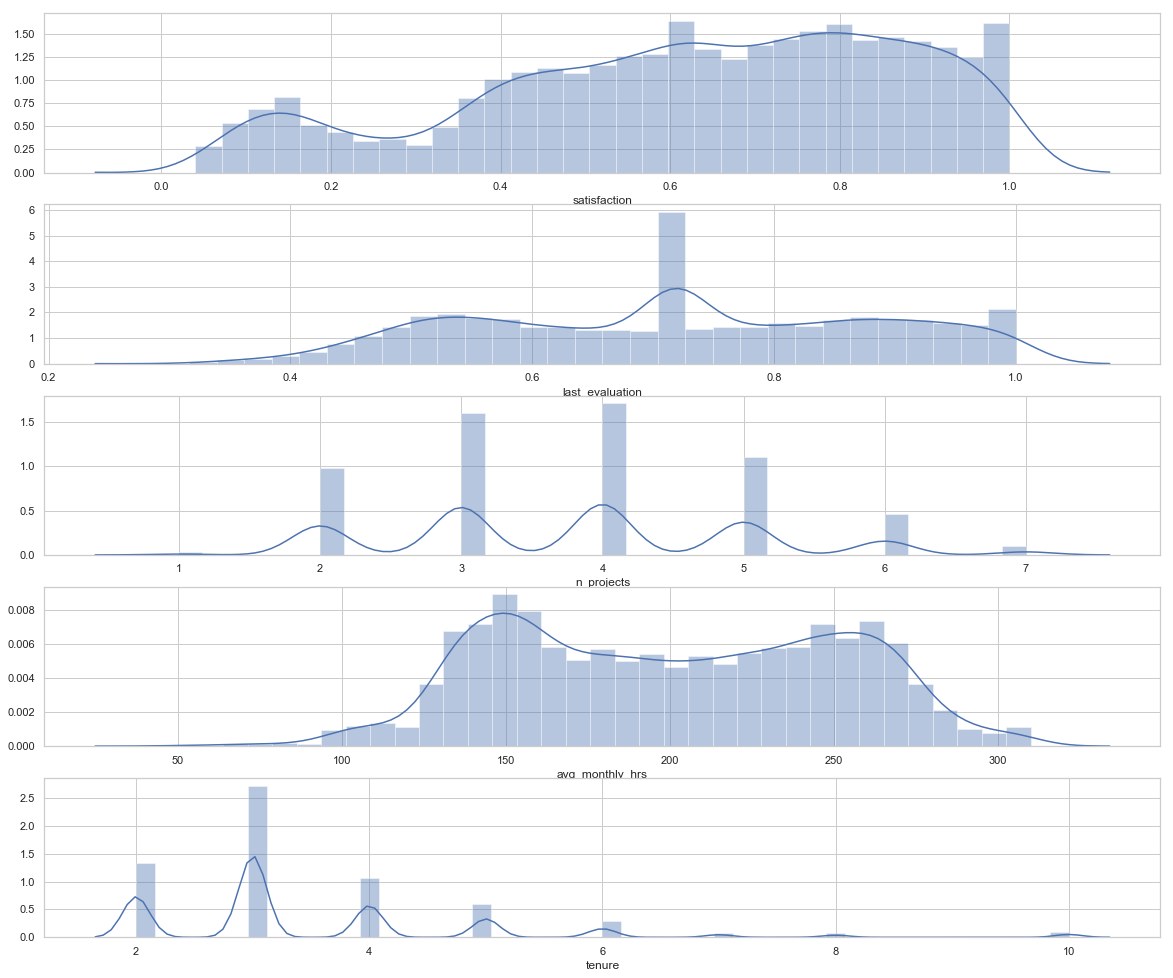

In [70]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(20,17))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)
sns.distplot(df['satisfaction'],ax = ax1);
sns.distplot(df['last_evaluation'], kde=True,ax=ax2);
sns.distplot(df['n_projects'], kde=True,ax=ax3);
sns.distplot(df['avg_monthly_hrs'], kde=True,ax=ax4);
sns.distplot(df['tenure'], kde=True,ax=ax5);

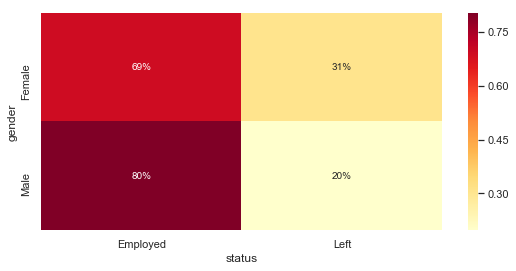

In [71]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['gender'], df['status'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

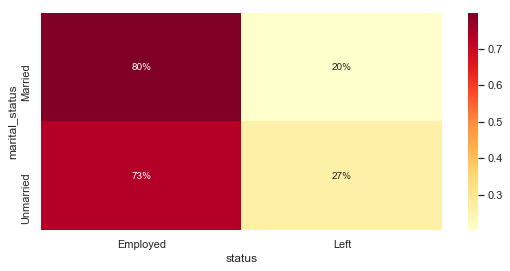

In [72]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['marital_status'], df['status'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

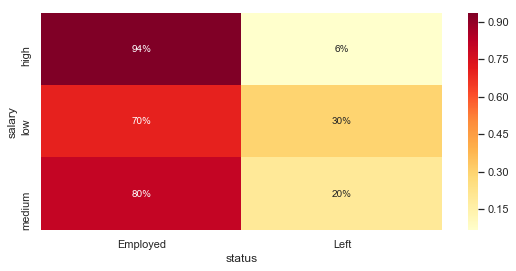

In [73]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['salary'], df['status'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

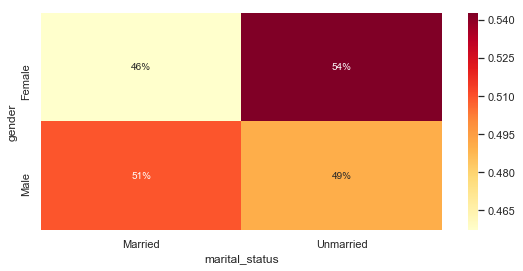

In [74]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['gender'], df['marital_status'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

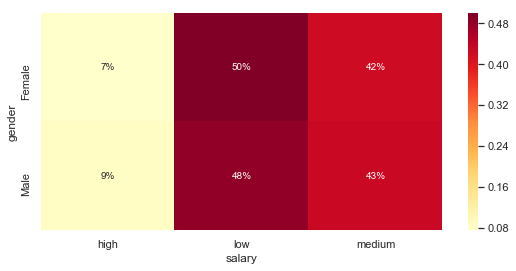

In [75]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['gender'], df['salary'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

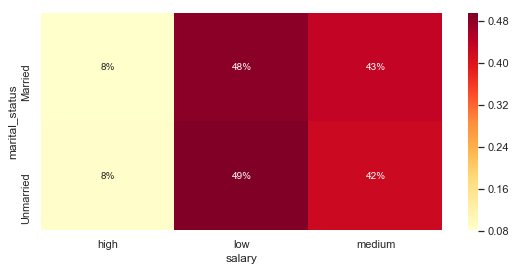

In [76]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['marital_status'], df['salary'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

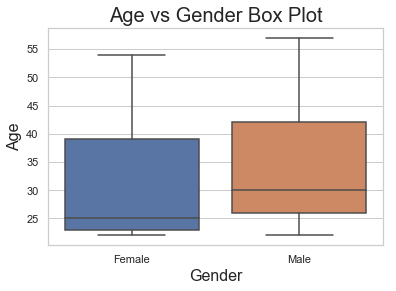

In [77]:
sns.boxplot(df['gender'], df['age'])
plt.title('Age vs Gender Box Plot', fontsize=20)      
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Age', fontsize=16)
plt.show()

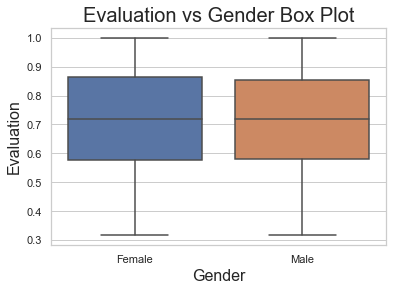

In [78]:
sns.boxplot(df['gender'], df['last_evaluation'])
plt.title('Evaluation vs Gender Box Plot', fontsize=20)      
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Evaluation', fontsize=16)
plt.show()

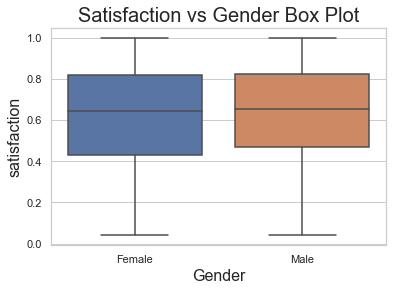

In [79]:
sns.boxplot(df['gender'], df['satisfaction'])
plt.title('Satisfaction vs Gender Box Plot', fontsize=20)      
plt.xlabel('Gender', fontsize=16)
plt.ylabel('satisfaction', fontsize=16)
plt.show()

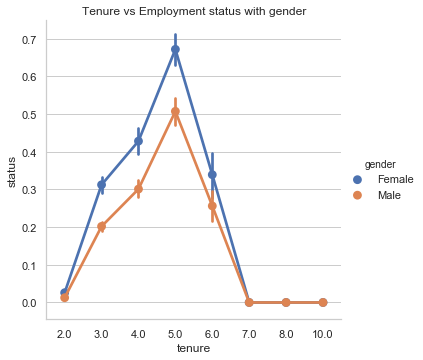

In [126]:
def plot9():
  
  
  temp = df.copy(deep=True)
  num = {"status": {"Left": 1, "Employed": 0}}
  
  temp.replace(num, inplace=True)
  
  sns.catplot('tenure','status', hue= 'gender', kind='point',data=temp)
  plt.title('Tenure vs Employment status with gender')
  
  
plot9()    

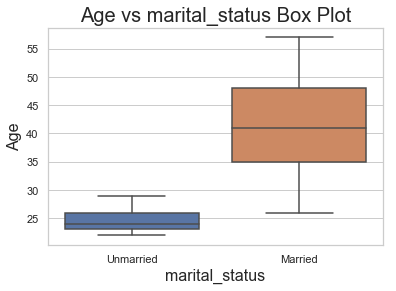

In [80]:
sns.boxplot(df['marital_status'], df['age'])
plt.title('Age vs marital_status Box Plot', fontsize=20)      
plt.xlabel('marital_status', fontsize=16)
plt.ylabel('Age', fontsize=16)
plt.show()

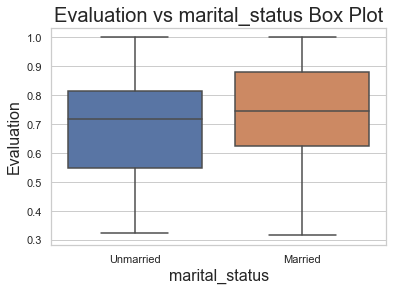

In [81]:
sns.boxplot(df['marital_status'], df['last_evaluation'])
plt.title('Evaluation vs marital_status Box Plot', fontsize=20)      
plt.xlabel('marital_status', fontsize=16)
plt.ylabel('Evaluation', fontsize=16)
plt.show()

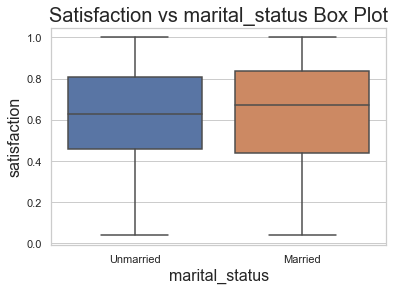

In [82]:
sns.boxplot(df['marital_status'], df['satisfaction'])
plt.title('Satisfaction vs marital_status Box Plot', fontsize=20)      
plt.xlabel('marital_status', fontsize=16)
plt.ylabel('satisfaction', fontsize=16)
plt.show()

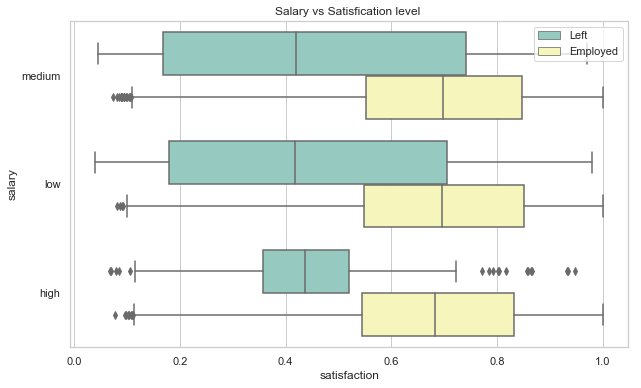

In [125]:
def plot6():
    # Plotting Salary against satisfcation 
    plt.figure(figsize=(10,6))
    
    sns.boxplot(x='satisfaction', y='salary', data=df, hue='status',palette='Set3')
    plt.legend(loc='upper right')
    plt.title('Salary vs Satisfication level ')
    plt.show()
plot6()

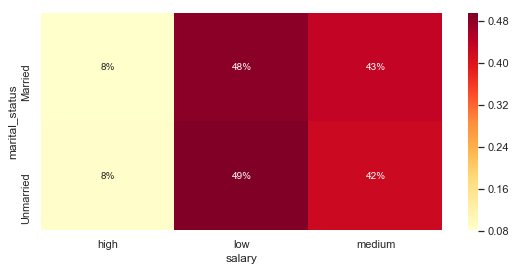

In [83]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['marital_status'], df['salary'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

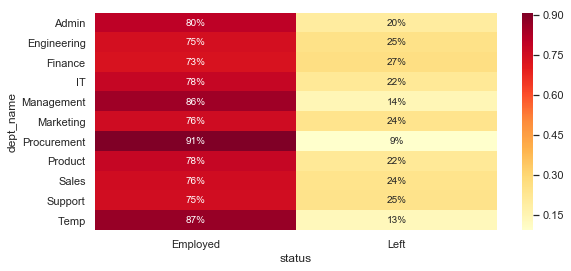

In [84]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['dept_name'], df['status'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

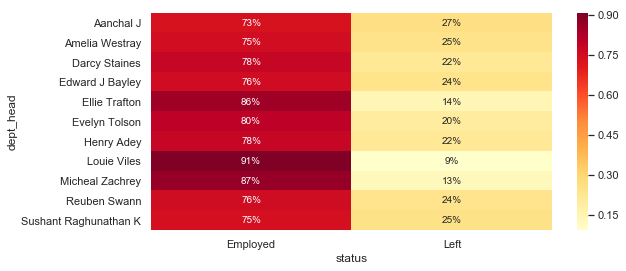

In [85]:
plt.figure(figsize=(9,4))
role_ed_xtab = pd.crosstab(df['dept_head'], df['status'], normalize='index')
sns.heatmap(role_ed_xtab, annot=True, fmt='0.0%', cmap='YlOrRd')

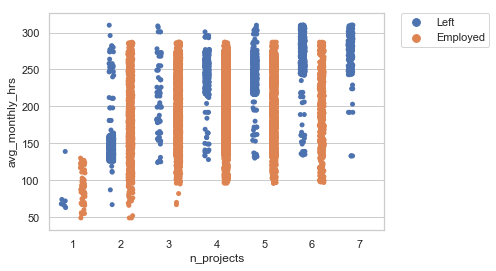

In [86]:
# stripplot
sns.stripplot(x='n_projects', y='avg_monthly_hrs', data=df, jitter=True, hue='status', dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

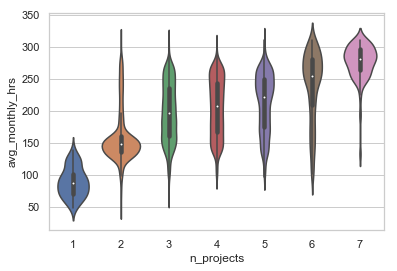

In [87]:
sns.violinplot(x='n_projects', y='avg_monthly_hrs', data=df)

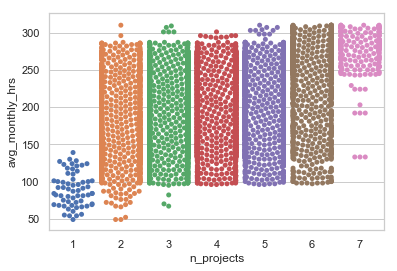

In [88]:
sns.swarmplot(x='n_projects', y='avg_monthly_hrs', data=df)

### Correlation Analysis

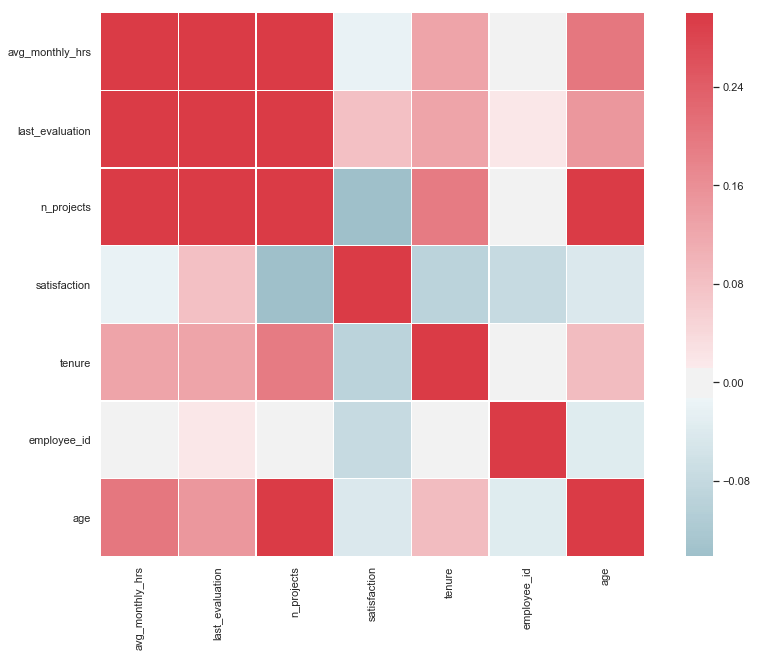

In [89]:
corr = df.corr()
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

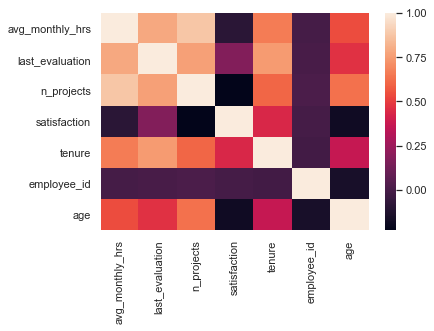

In [90]:
corr = left_df.corr()
sns.heatmap(corr)

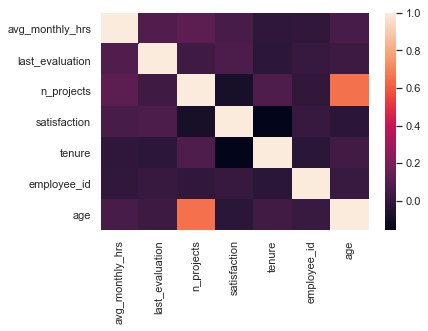

In [91]:
corr = employed_df.corr()
sns.heatmap(corr)

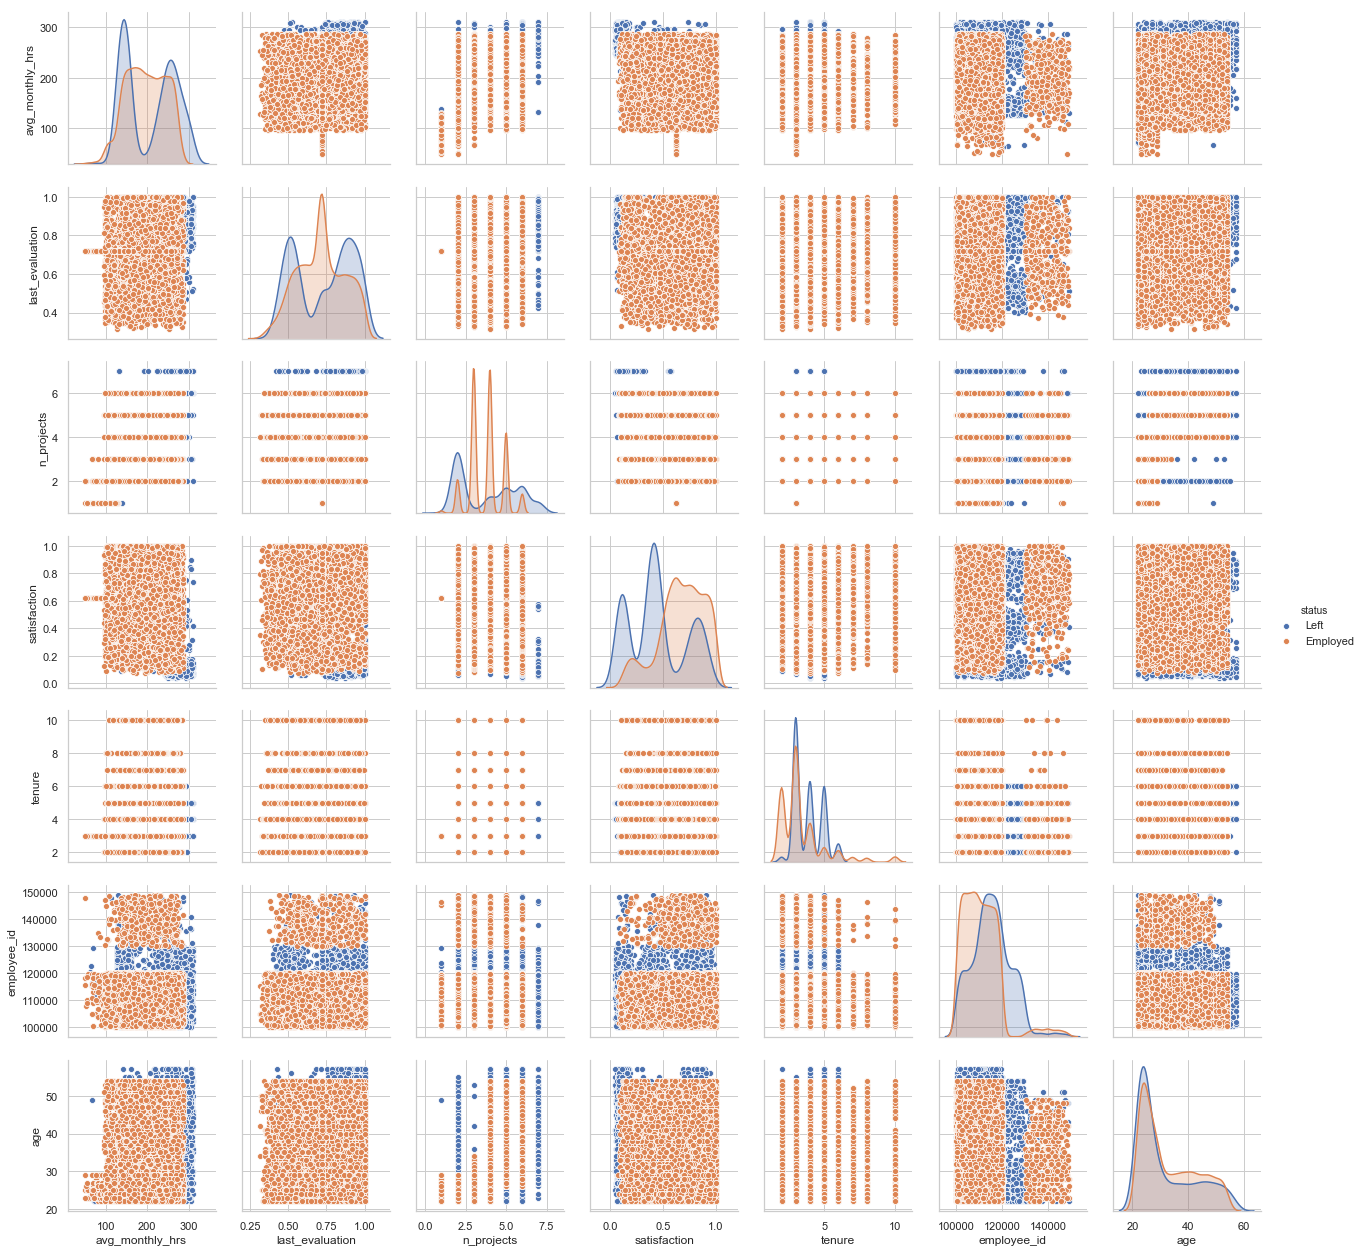

In [92]:
sns.pairplot(data=df,kind='scatter', hue='status')

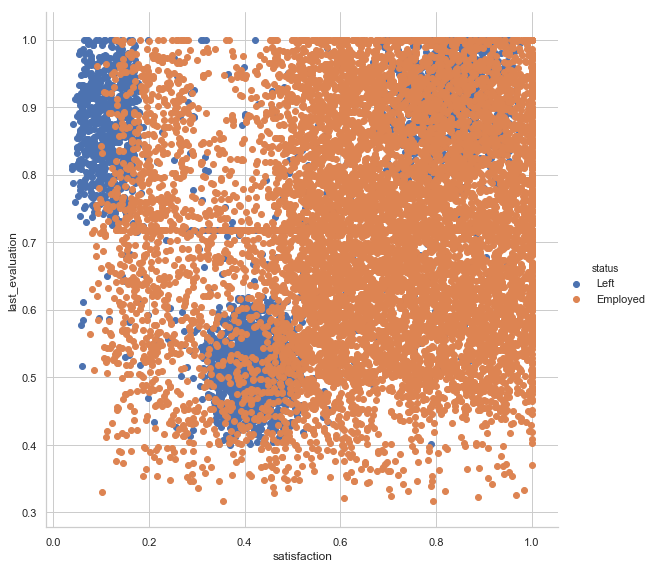

In [93]:
sns.FacetGrid(df, hue="status", height=8) \
    .map(plt.scatter, "satisfaction", "last_evaluation") \
    .add_legend();
plt.show();

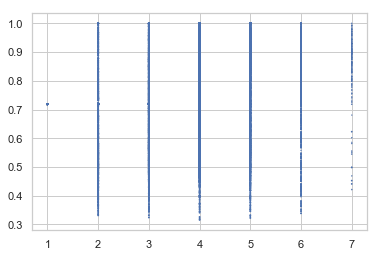

In [94]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df['n_projects'],df['last_evaluation'], s=df['satisfaction']) # Added third variable income as size of the bubble
plt.show()

Text(0.5, 1.0, 'Age vs Evaluation Scatter Plot')

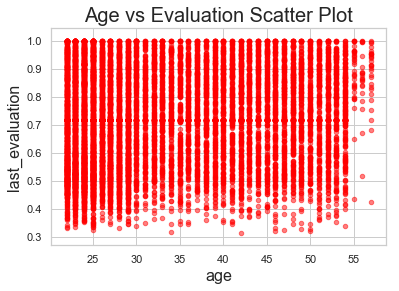

In [95]:
df.plot(kind='scatter', x='age', y='last_evaluation',alpha = 0.5,color = 'red')
plt.xlabel('age', fontsize=16)             
plt.ylabel('last_evaluation', fontsize=16)
plt.title('Age vs Evaluation Scatter Plot', fontsize=20)           

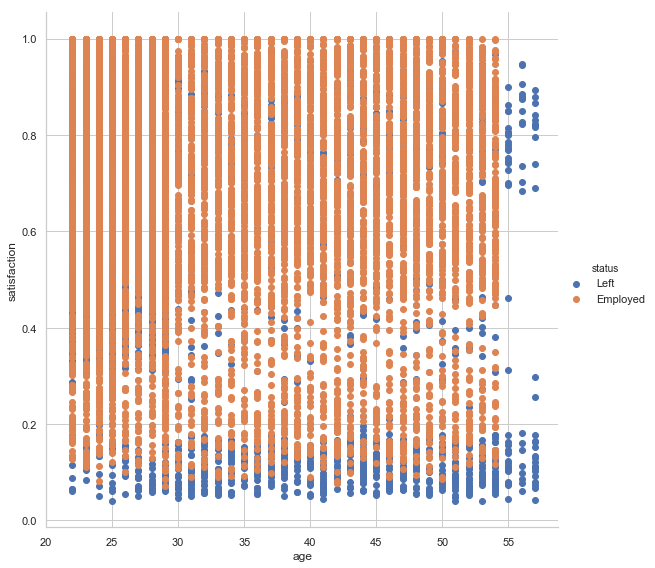

In [96]:
sns.FacetGrid(df, hue="status", height=8) \
    .map(plt.scatter, "age", "satisfaction") \
    .add_legend();
plt.show();

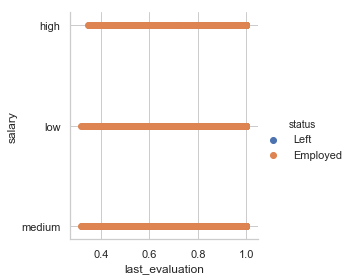

In [97]:
sns.FacetGrid(df, hue="status", height=4) \
    .map(plt.scatter, "last_evaluation", "salary") \
    .add_legend();
plt.show();

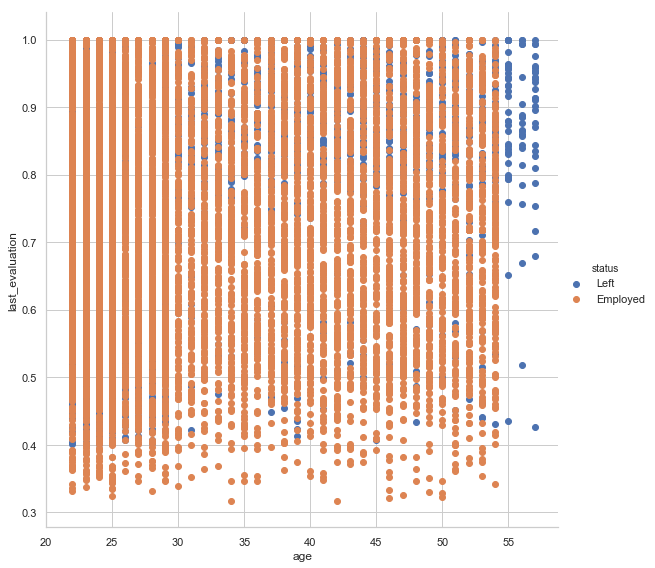

In [98]:
sns.FacetGrid(df, hue="status", height=8) \
    .map(plt.scatter, "age", "last_evaluation") \
    .add_legend();
plt.show();

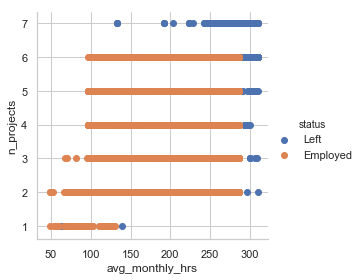

In [99]:
sns.FacetGrid(df, hue="status", height=4) \
    .map(plt.scatter, "avg_monthly_hrs", "n_projects") \
    .add_legend();
plt.show();

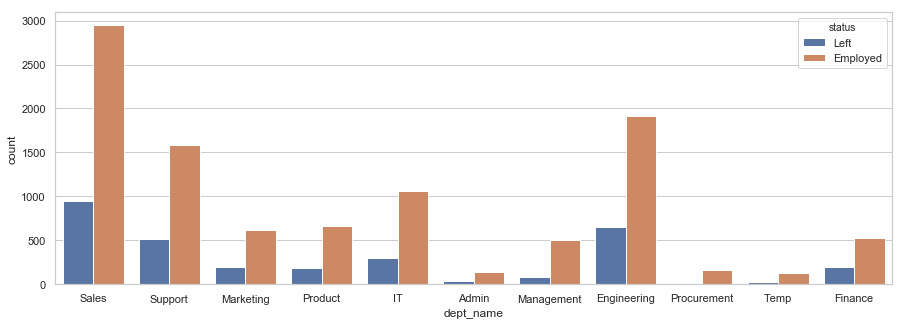

In [100]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.countplot(x='dept_name', hue="status", data=df, ax=axis1)

In [101]:
departments = df['dept_name'].unique()
departments = departments[departments != 'unknown']
departments

array(['Sales', 'Support', 'Marketing', 'Product', 'IT', 'Admin',
       'Management', 'Engineering', 'Procurement', 'Temp', 'Finance'],
      dtype=object)

In [102]:
print ("Department  - Employees % - Dept. Attrition % - Overall Attrition %")
for dept in departments:
    print ("%-11s - %-11.2f - %-17.2f - %-6.2f" %(dept, \
                                        df[(df['dept_name'] == dept)]['dept_name'].count()/df['dept_name'].count() * 100, \
                                        df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['dept_name'] == dept)]['dept_name'].count() * 100, \
                                        df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['status'] == "Left")]['dept_name'].count() * 100))

Department  - Employees % - Dept. Attrition % - Overall Attrition %
Sales       - 29.05       - 24.36             - 30.13 
Support     - 15.72       - 24.62             - 16.48 
Marketing   - 6.06        - 24.01             - 6.19  
Product     - 6.36        - 21.92             - 5.94  
IT          - 10.13       - 21.85             - 9.43  
Admin       - 1.30        - 20.00             - 1.11  
Management  - 4.40        - 14.41             - 2.70  
Engineering - 19.19       - 25.42             - 20.76 
Procurement - 1.29        - 9.25              - 0.51  
Temp        - 1.12        - 13.33             - 0.63  
Finance     - 5.38        - 26.73             - 6.13  


In [103]:
employee_count_by_department = np.zeros(len(departments))
dept_attrition = np.zeros(len(departments))
overall_attrition = np.zeros(len(departments))
i = 0
for dept in departments:
    employee_count_by_department[i] = df[(df['dept_name'] == dept)]['dept_name'].count()/df['dept_name'].count() * 100
    dept_attrition[i] = df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['dept_name'] == dept)]['dept_name'].count() * 100
    overall_attrition[i] = df[(df['dept_name'] == dept) & (df['status'] == "Left")]['dept_name'].count()/df[(df['status'] == "Left")]['dept_name'].count() * 100
    i += 1

attrition_df = pd.DataFrame({'Employee_Percentage': employee_count_by_department, 'Dept_attrition': dept_attrition, 'Overall_attrition': overall_attrition}, index=departments)
attrition_df

,Employee_Percentage,Dept_attrition,Overall_attrition
Sales,29.045488,24.364570,30.126984
Support,15.719612,24.620493,16.476190
Marketing,6.055183,24.014778,6.190476
Product,6.360925,21.922626,5.936508
IT,10.134228,21.854305,9.428571
Admin,1.304996,20.000000,1.111111
Management,4.399702,14.406780,2.698413
Engineering,19.187174,25.417800,20.761905
Procurement,1.290082,9.248555,0.507937
Temp,1.118568,13.333333,0.634921


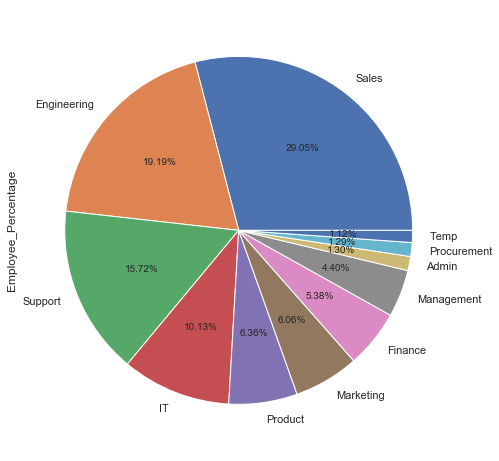

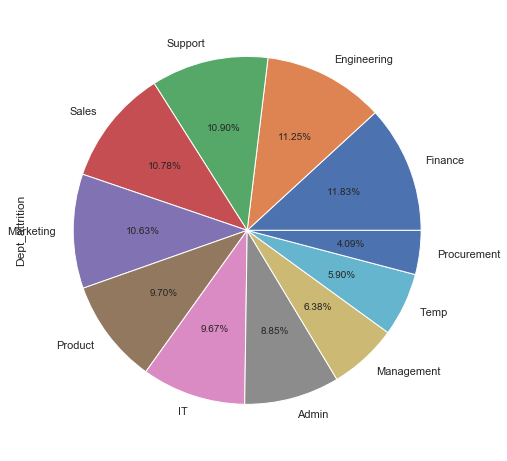

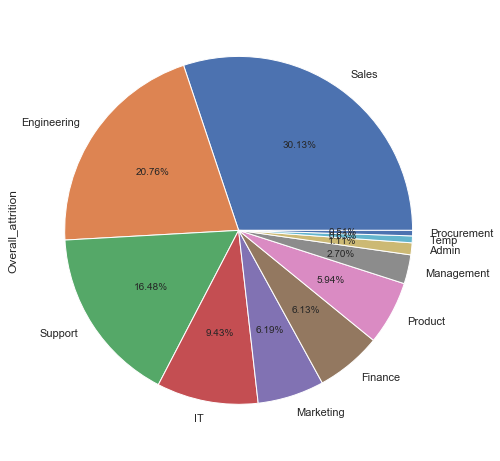

In [104]:
attrition_df.sort_values(by='Employee_Percentage', ascending=False).plot.pie('Employee_Percentage', legend=False, autopct='%.2f%%', figsize=(8,8))
attrition_df.sort_values(by='Dept_attrition', ascending=False).plot.pie('Dept_attrition', legend=False, autopct='%.2f%%', figsize=(8,8))
attrition_df.sort_values(by='Overall_attrition', ascending=False).plot.pie('Overall_attrition', legend=False, autopct='%.2f%%', figsize=(8,8))

### Which departments whose people leave most often?

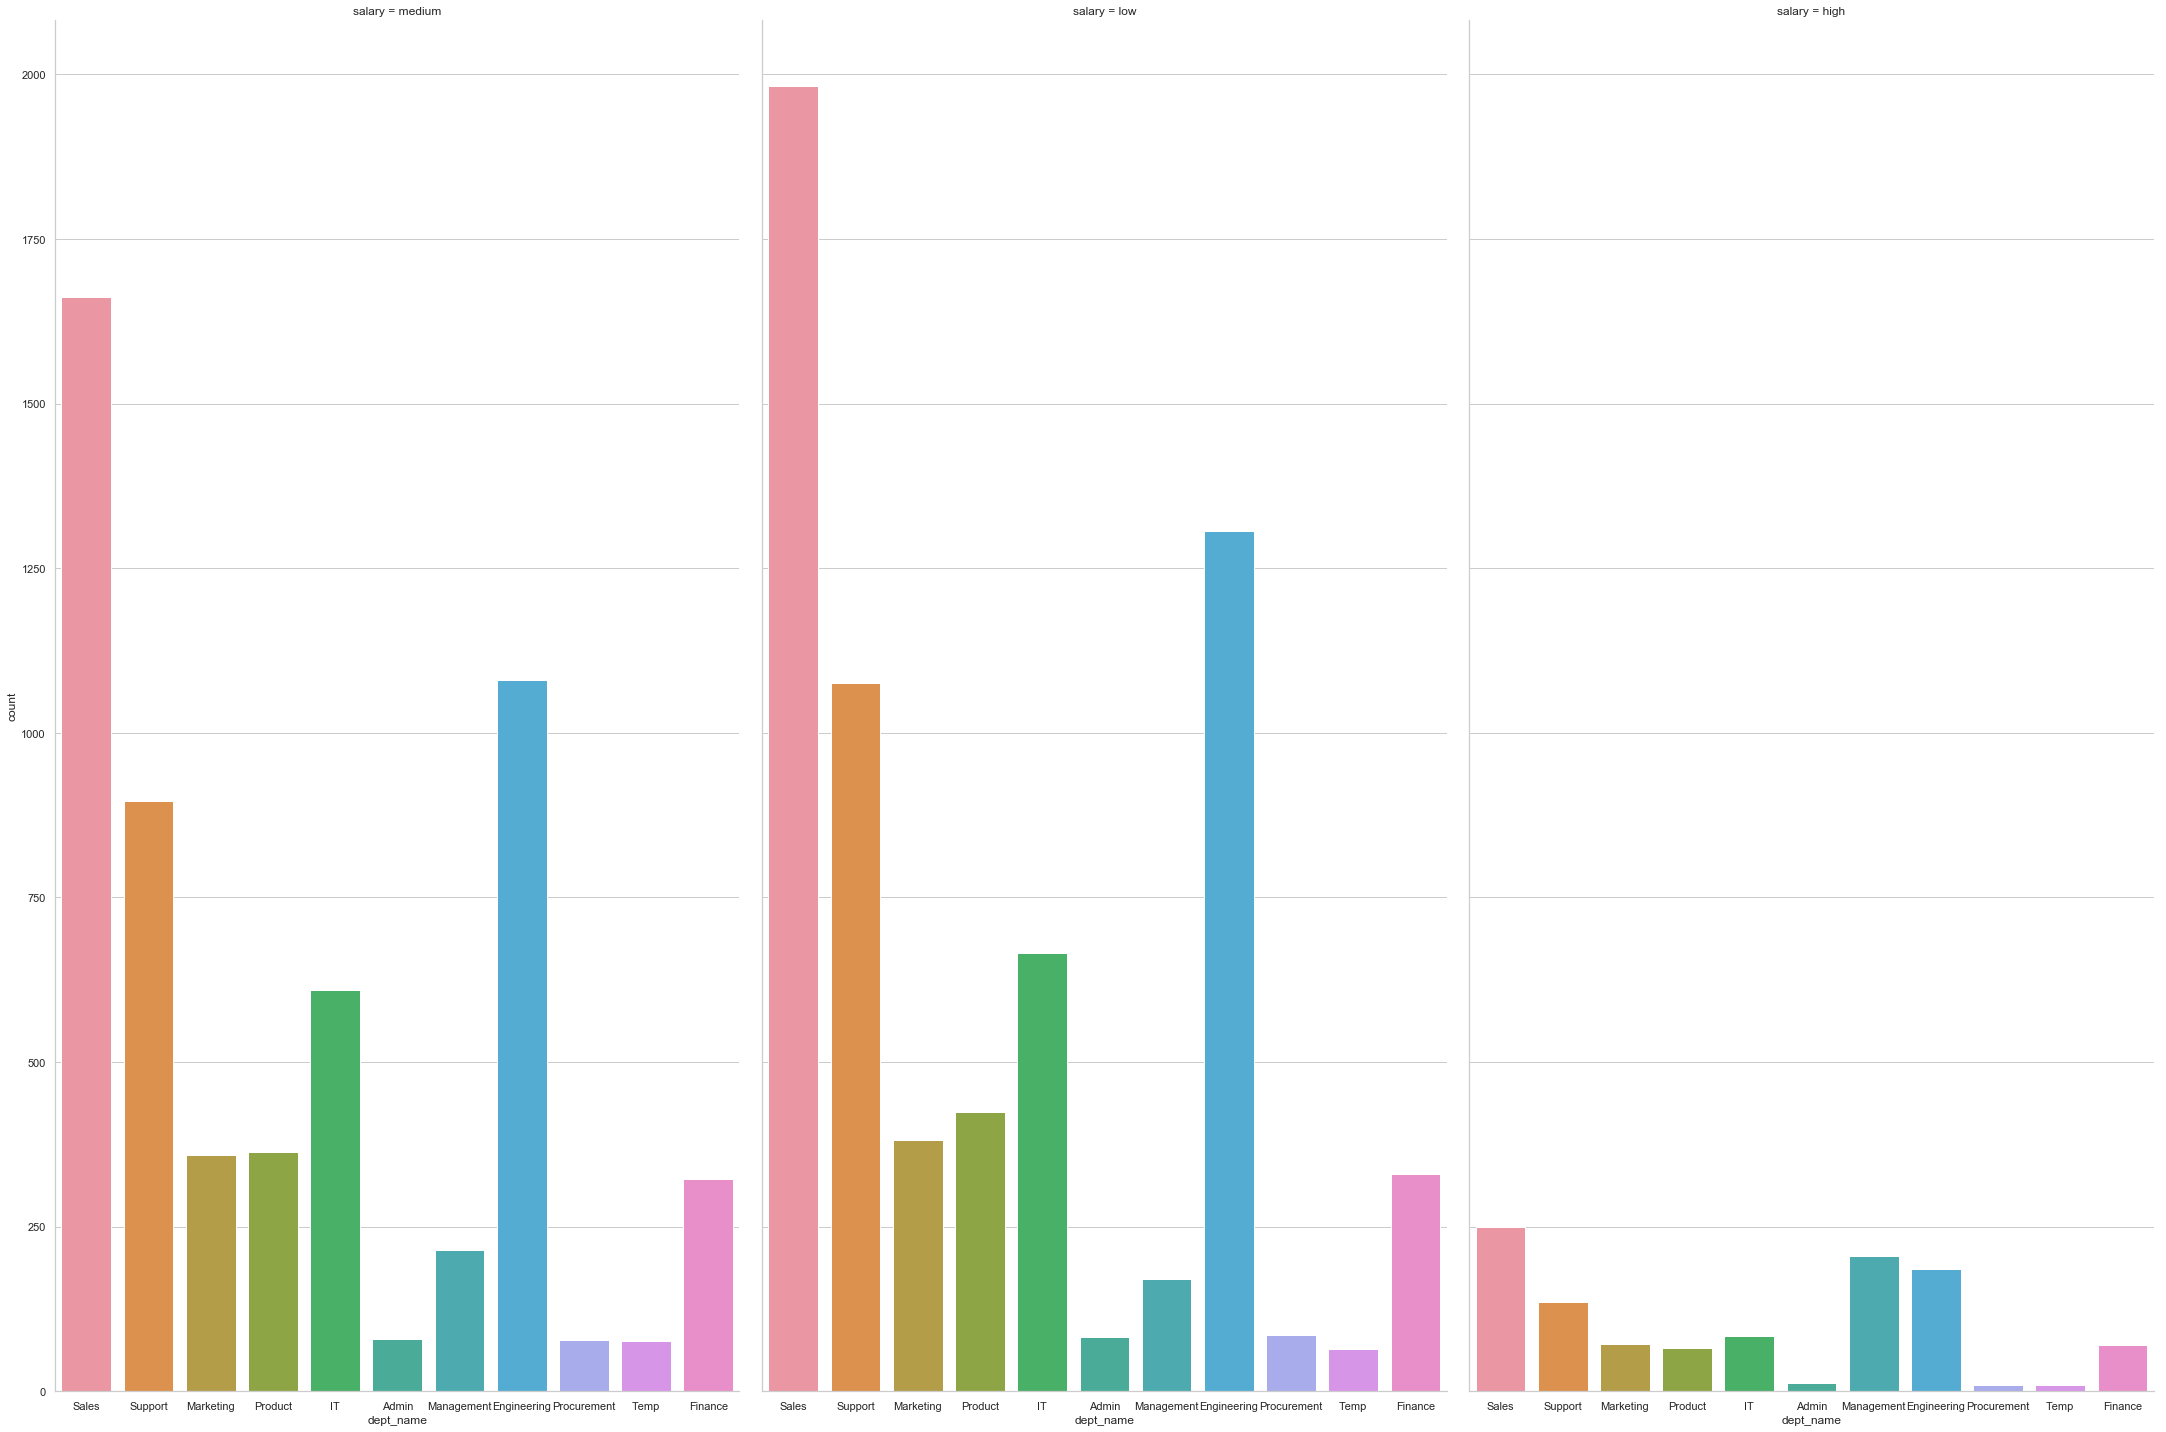

In [105]:
sns.catplot(x="dept_name",data=df,col="salary",kind="count",aspect=0.5,height=20)

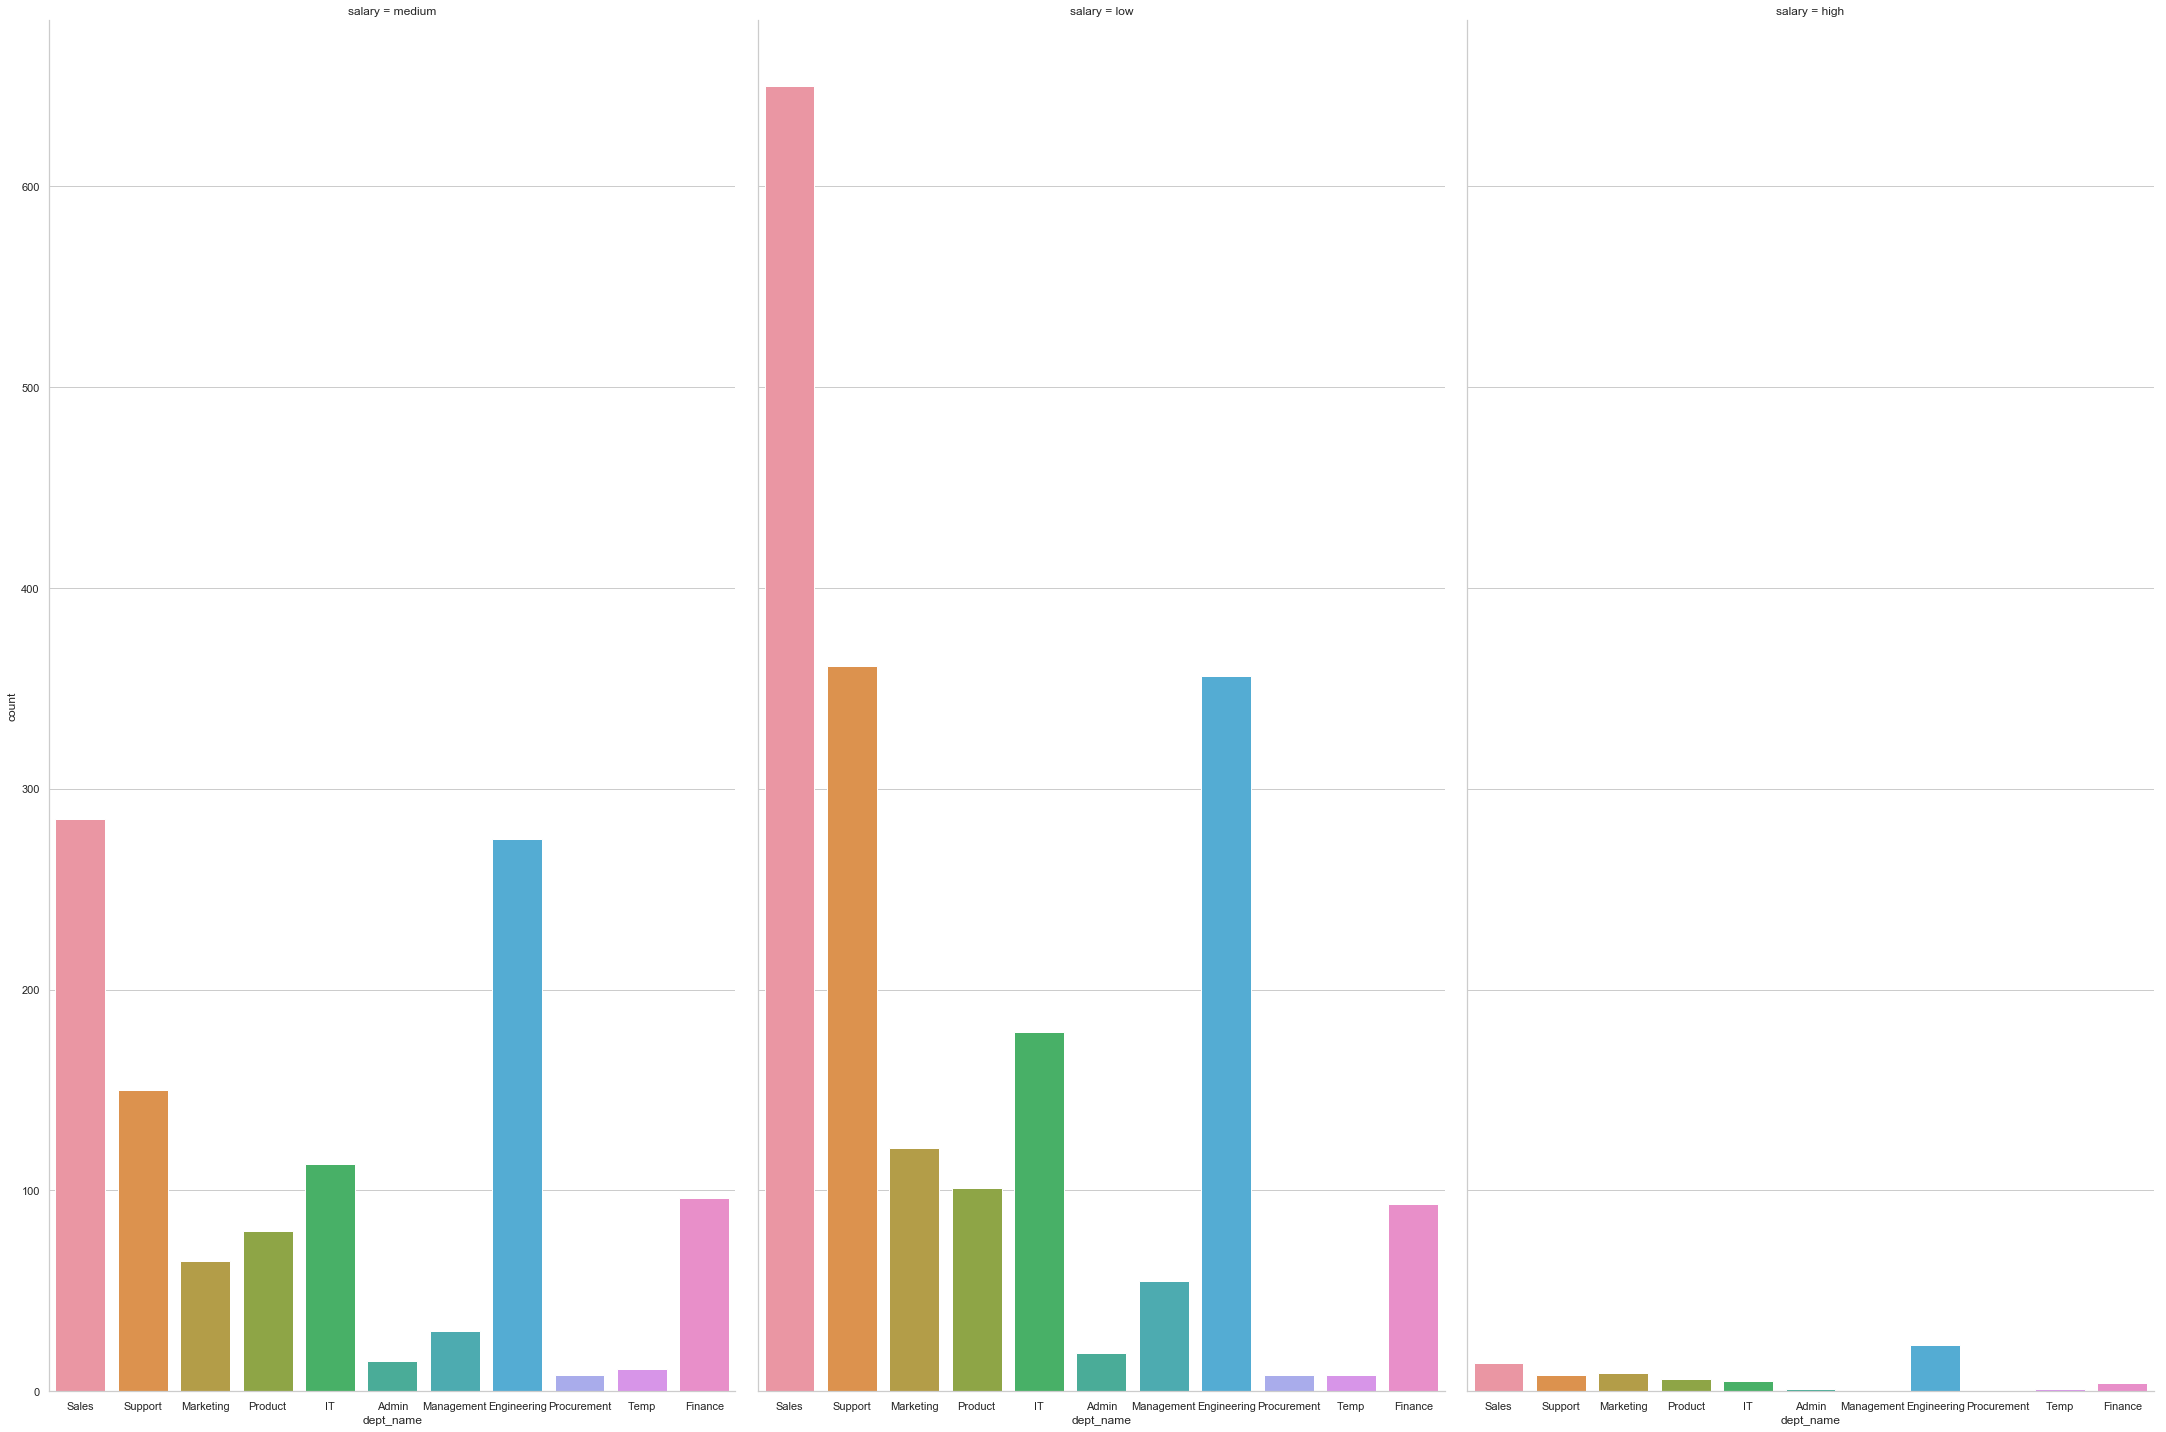

In [106]:
sns.catplot(x="dept_name",data=left_df,col="salary",kind="count",aspect=0.5,height=20)

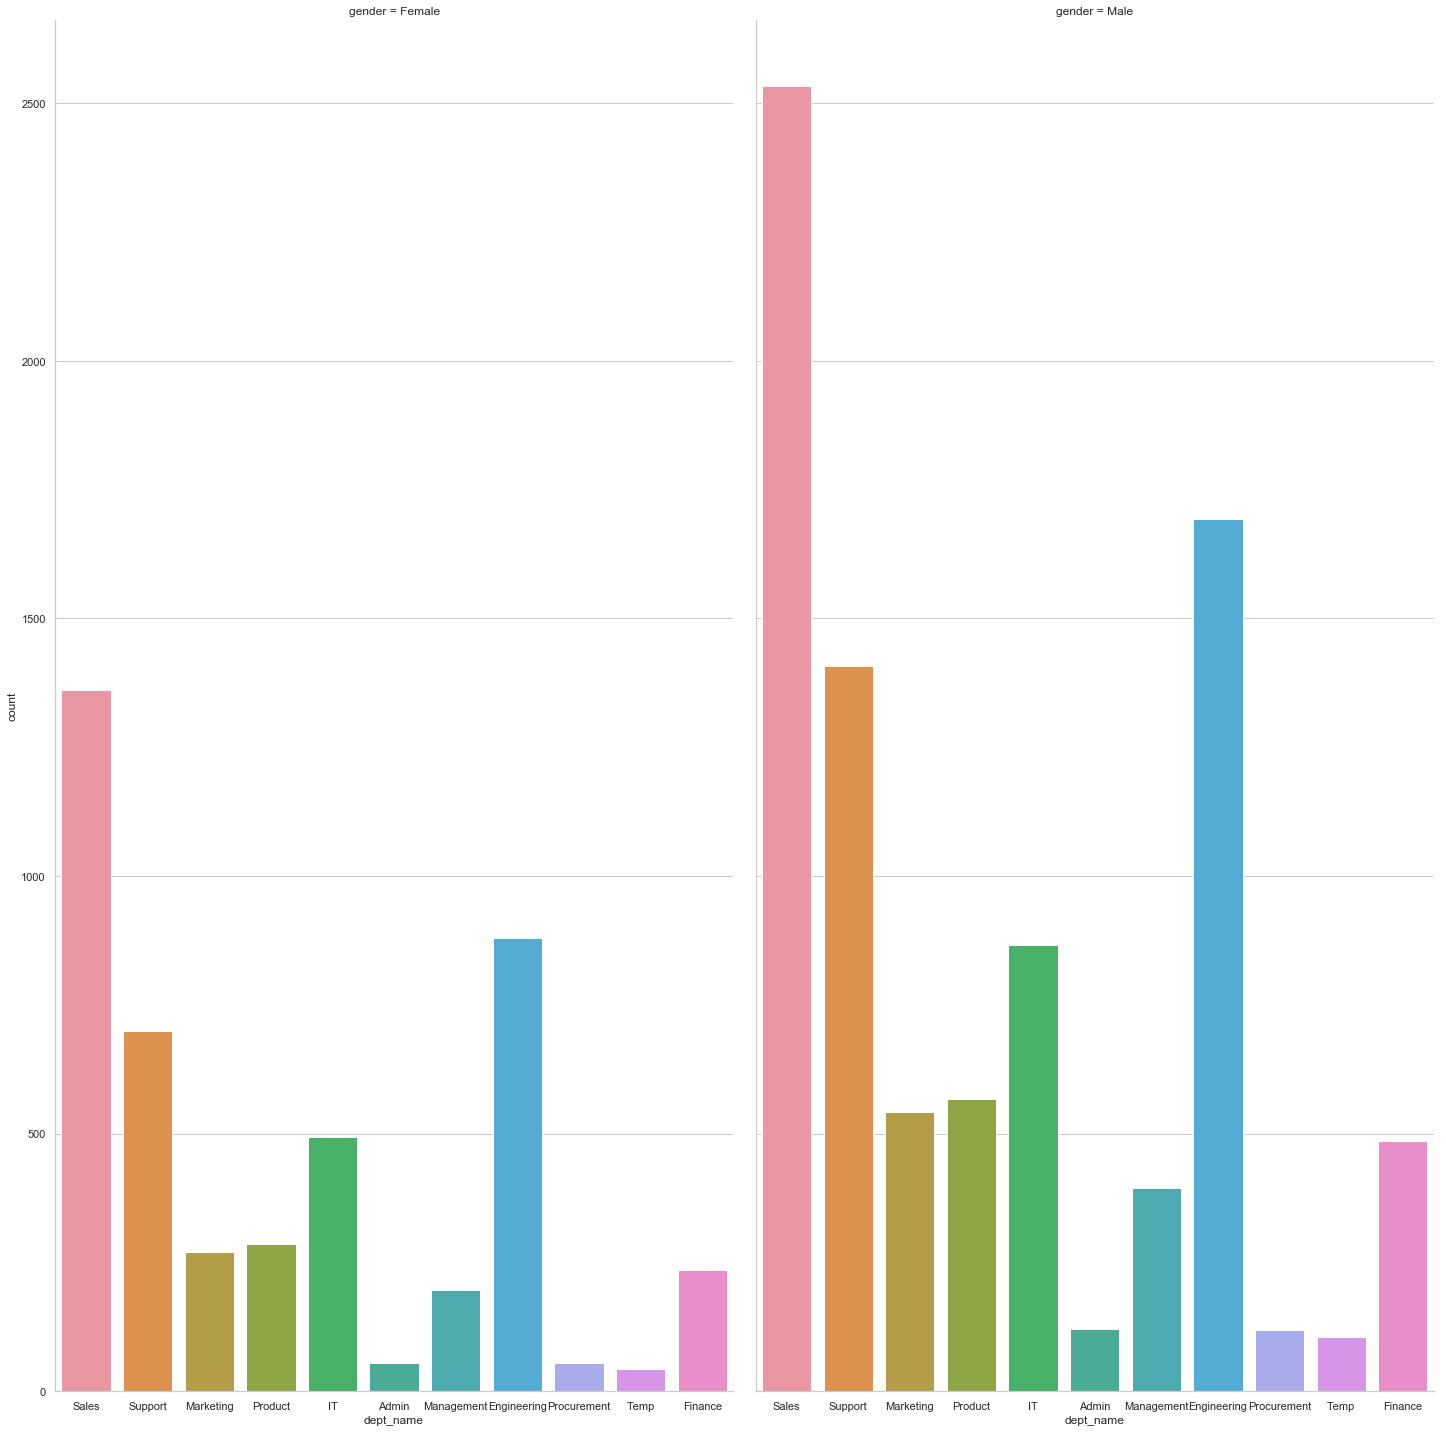

In [107]:
sns.catplot(x="dept_name",data=df,col="gender",kind="count",aspect=0.5,height=20)

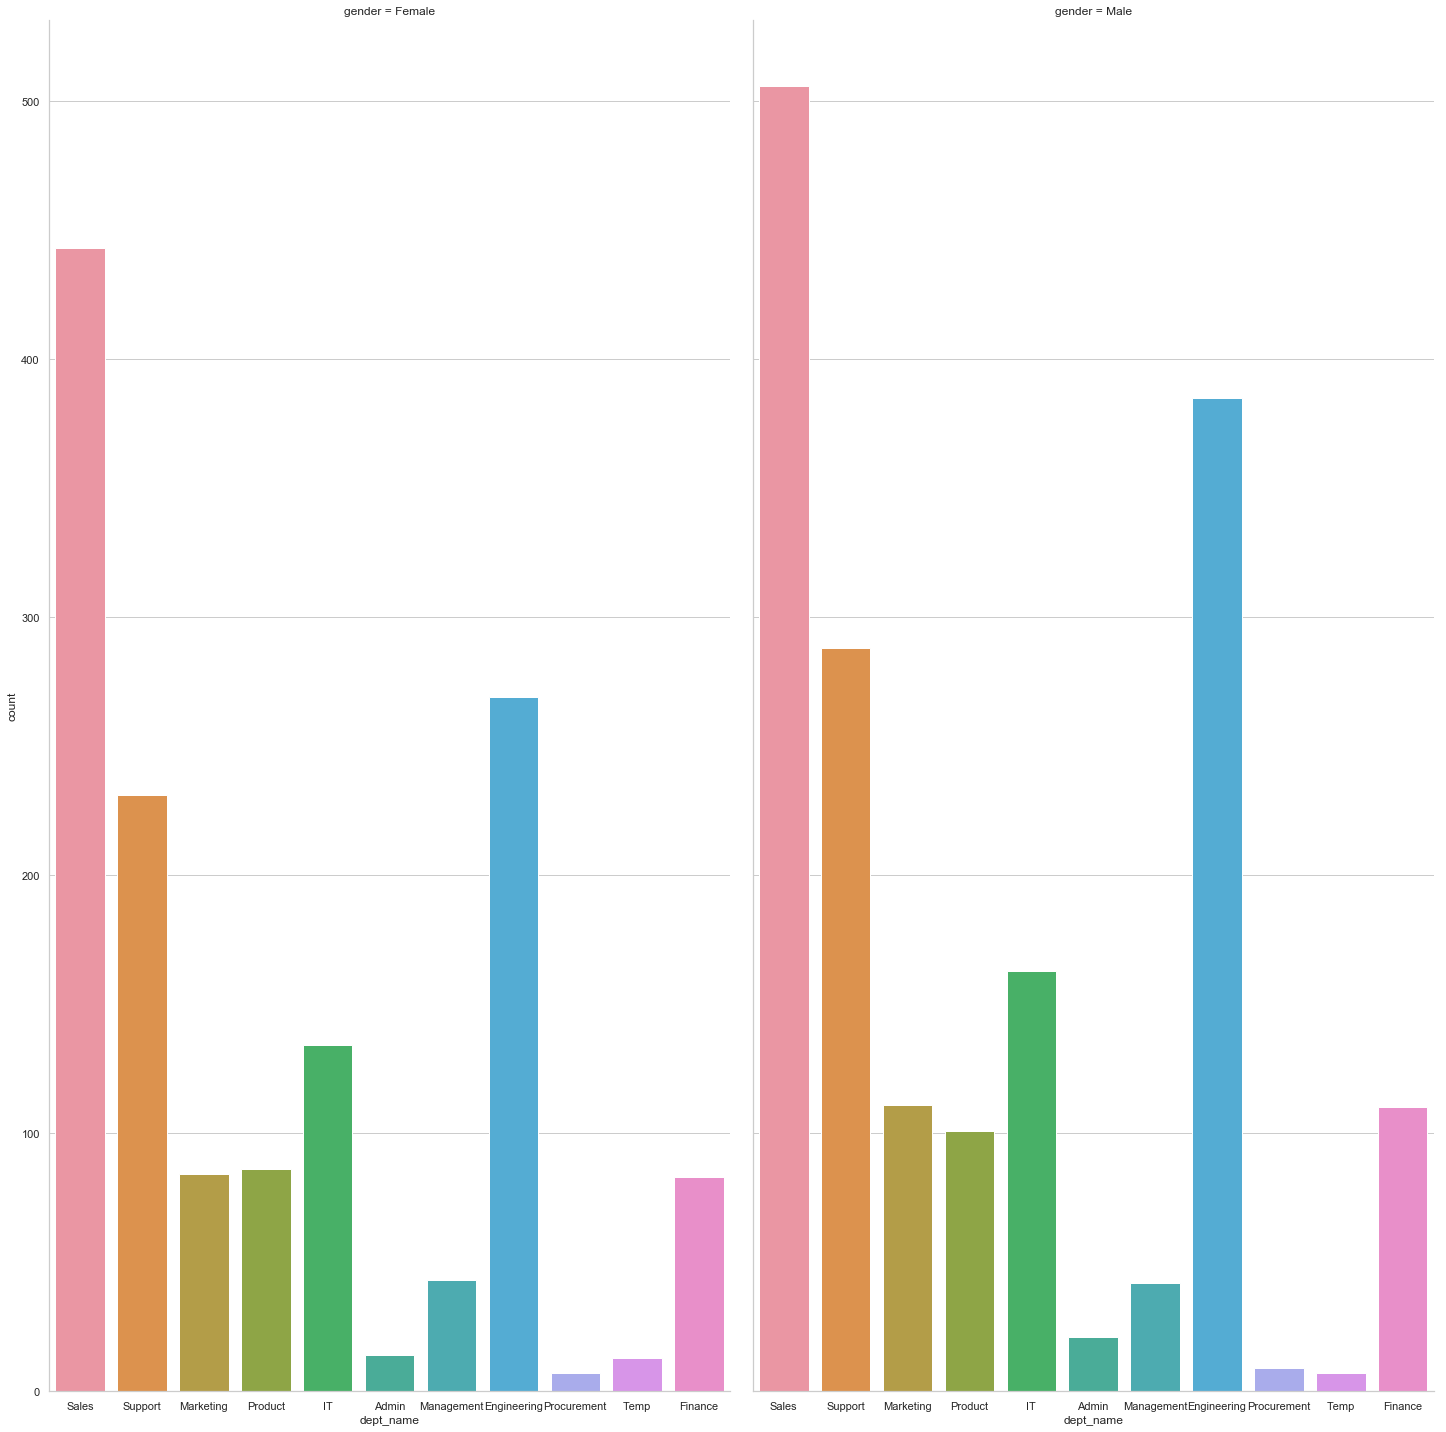

In [108]:
sns.catplot(x="dept_name",data=left_df,col="gender",kind="count",aspect=0.5,height=20)

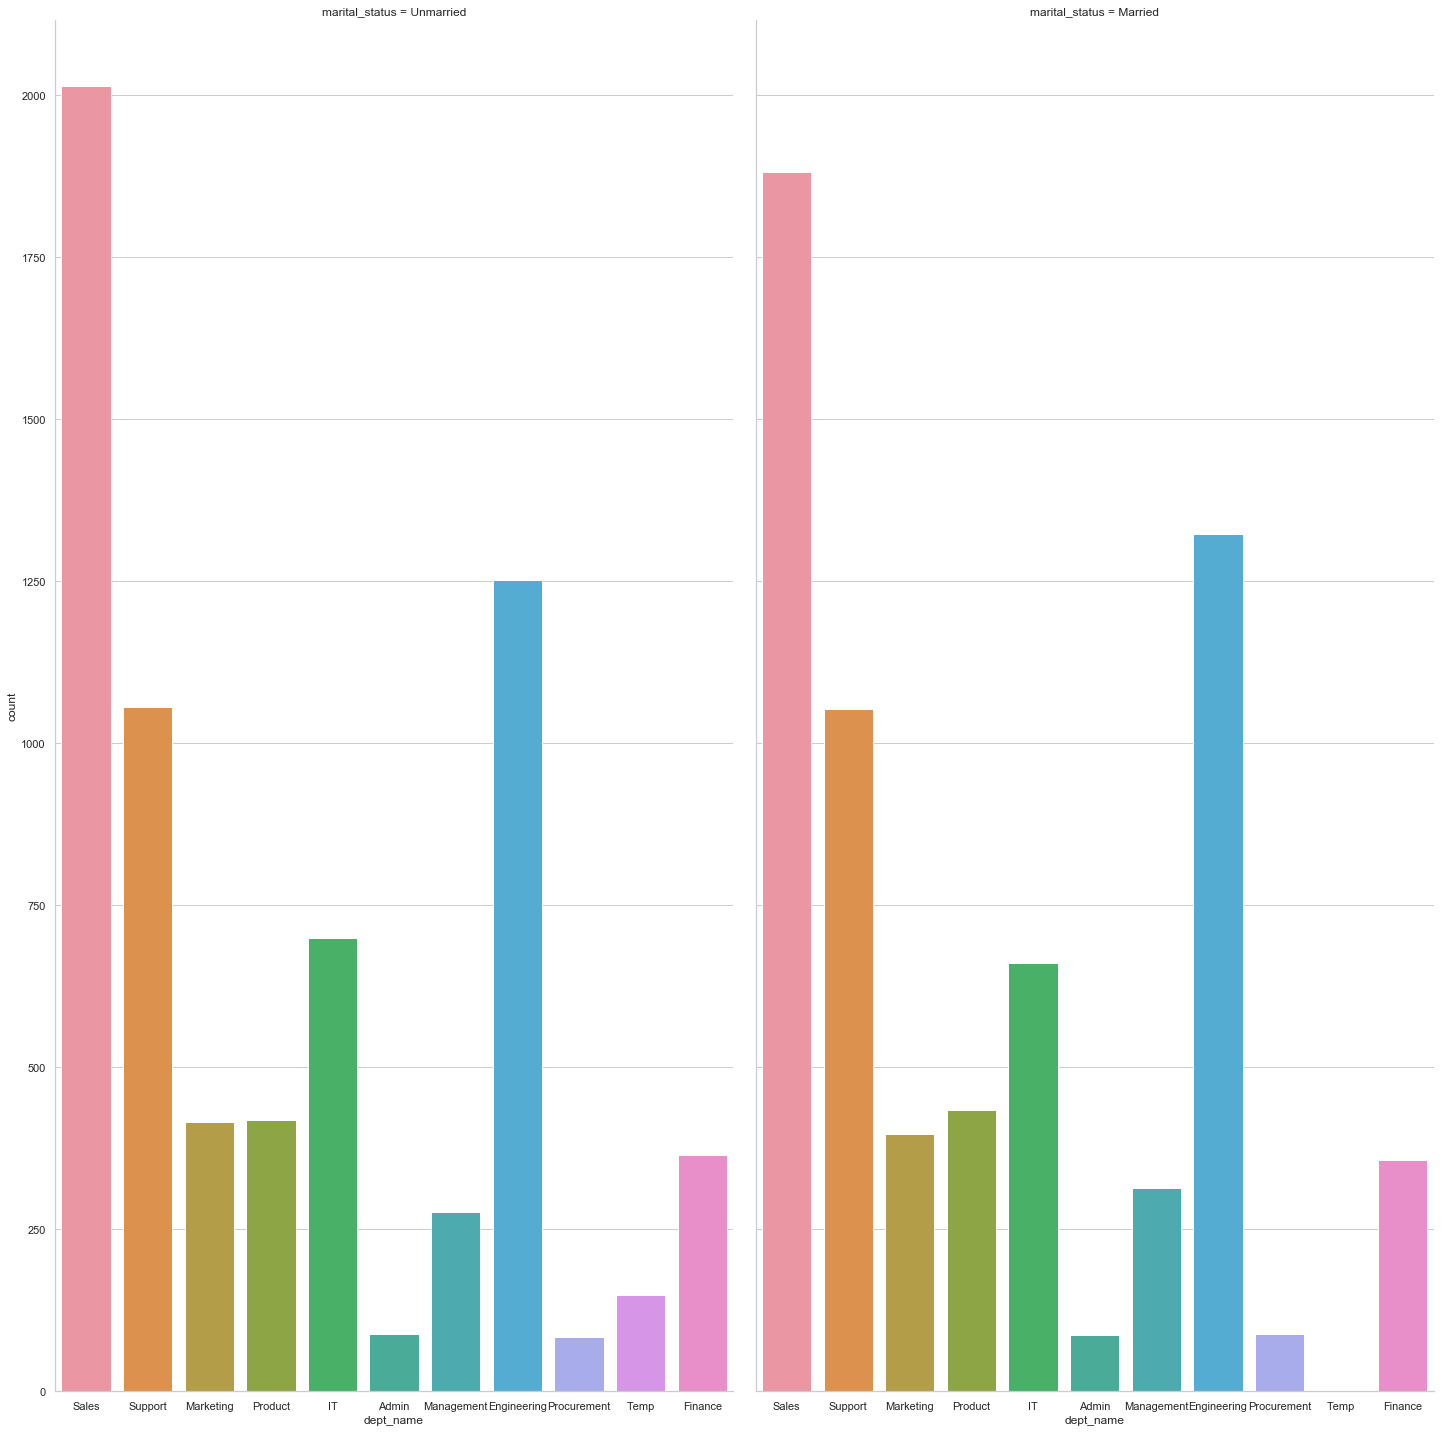

In [109]:
sns.catplot(x="dept_name",data=df,col="marital_status",kind="count",aspect=0.5,height=20)

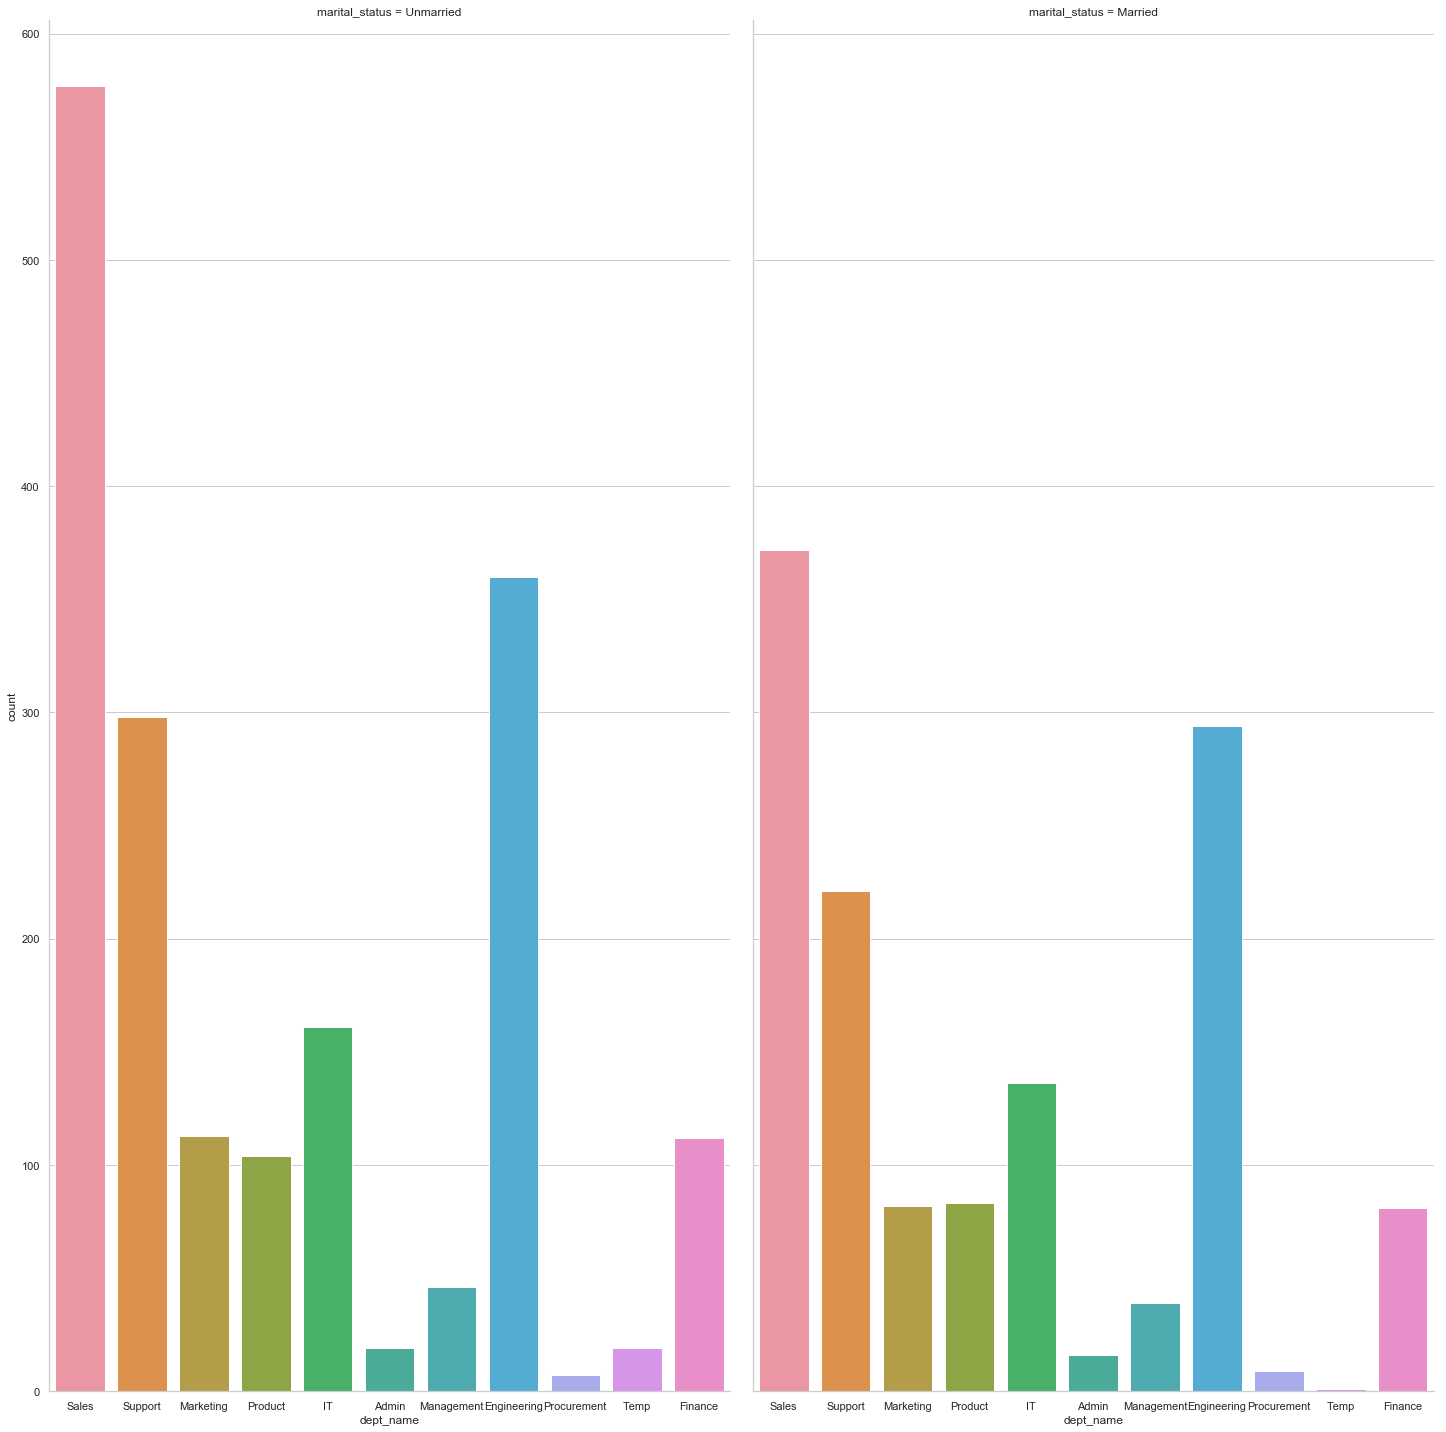

In [110]:
sns.catplot(x="dept_name",data=left_df,col="marital_status",kind="count",aspect=0.5,height=20)

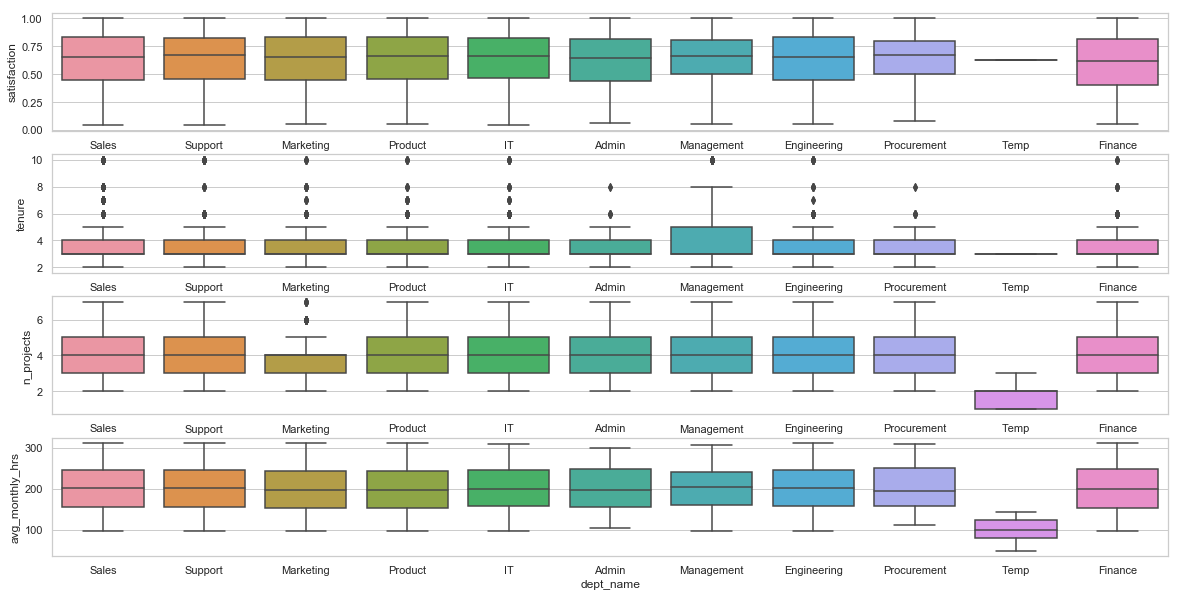

In [111]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.boxplot(x="dept_name",y="satisfaction",data=df,ax=ax1)
sns.boxplot(x="dept_name",y="tenure",data=df,ax=ax2)
sns.boxplot(x="dept_name",y="n_projects",data=df,ax=ax3)
sns.boxplot(x="dept_name",y="avg_monthly_hrs",data=df,ax=ax4)

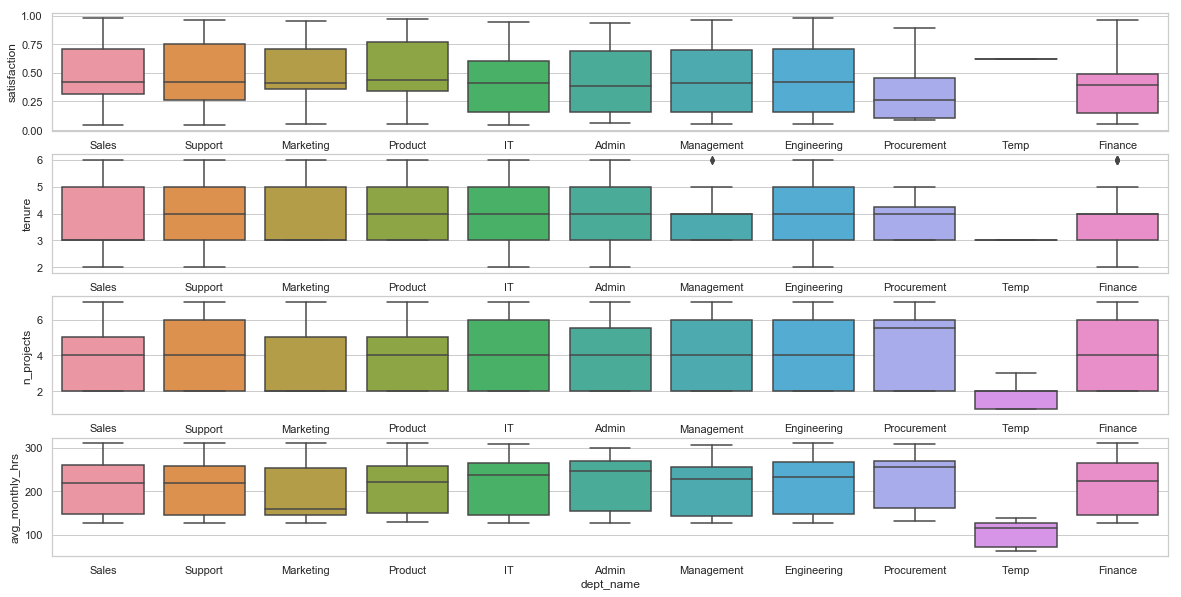

In [112]:
# Create a figure instance, and the two subplots
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sns.boxplot(x="dept_name",y="satisfaction",data=left_df,ax=ax1)
sns.boxplot(x="dept_name",y="tenure",data=left_df,ax=ax2)
sns.boxplot(x="dept_name",y="n_projects",data=left_df,ax=ax3)
sns.boxplot(x="dept_name",y="avg_monthly_hrs",data=left_df,ax=ax4)

### Insights: Profile of the people who left

    satisfaction: Employees who left include both satisfied and dissatisfied with their job.
    last_evaluation: People leaving the company are majorly high and low performers. 
    So it could be that they did not get the right opportunities to work or maybe they got better opportunities elsewhere.
    n_projects: Most people are working on 2 projects.
    avg_montly_hrs: The average of 160 to 220 hours working people seem to be staying back. Those who are working less seem to be disconnected (lack of interest, motivation, etc.) and those working overtime seemed to be stressed.
    tenure: 3-5 years seems to be the age range where people decide if they want to stay back or leave. 
    
### Insights: Correlated Elements

    n_projects and avg_monthly_hrs: More the projects, more the time you spend on them. This could be possibly the reason of dissatisfaction.
    last_evaluation and avg_monthly_hrs: This indicates that the longer the monthly hours, the more likely you get a good last evaluation. 
    satisfaction and tenure: They have decent correlation
    avg_monthly_hrs and age: Very strong correlation so indicates young people tend to work more
    n_projects and age:Same as above
    
### Insights: Departmental Data
    The satisfaction level in Sales, engineering and support department is actually higher than procurement and finance. This means that probably they left because of low salary.
    Procurement and Finance have the lowest satisfaction level with most of the quartiles located below 0.5. So that could account for the attrition in finance but not procurement team. Procurement team is handling more projects and their working hours are still in the niche region. Work Balance might be the critical factor there.
    Marketing and product have high satisfaction levels despite high rate of quitting owing low salary.
    One interesting observation is that married people tend to quit less compared to unmarried. This is probably that the former wants more settlement than risk taking attitude in former.
    Also the amount of women quitting is quite alarming. This is probable due to marriage, child care, etc.

### Observations
    1. Employee status Vs Age :
        a. We observed that large numer of employees are from age 20 to 35 years and the attrition rate of the employees are more in the same age group.  Greater the experience less is the attrition rate.
					
    2. Graph - Employee status with respect to Last Evaluation:
        a. We observed the graph for the employees evaluated between 0.4 to 0.6 and 0.8 to 1. 
        Lesser evaluation relates to low performance and greater evaluation relates to highly skilled employees. 
        In both the scenarios attrition rate is high. Employees between 0.6 to 0.8 comes under the mid range who are stable in the organization.
					
    3. Employee satisfaction is a very important role in attriton, if employee are satisfied then the attrition rate would be less. Employee having satisfaction rate 0.5 to 1 are the satisfied employees and they are working in the organization. Majority of the employees below 0.5 satisfaction rate left the organization.
    
    4. If we observe the tenure column, we can see that employee left the organization within a tenure of 3 to 5. More the number of years of experience, the employee stays in the organisation.
					
    5. There are almost 50% of female employees as compared to the male employees. If we observe the gender graph, attrition rate of female is more. HR team should make all possibe changes to the policies for women to reduce the attrition rate by some extent for e.g. work from home facility and child care facility. Most women quit or take a break from the work. We can encourage female employees by providing good policies, work from home facility etc.	
					
    6. last_evaluation Vs satisfaction with respect to the employee status:
       We observed three clusters. Employees are getting clubbed, they are related to each other. There is dissatisfaction among those who are performing very good as well as those performing very bad.	
					
    7. If we observe the average working hours of employees, employee who left the organization either work very less i.e. between 125 to 175 hrs and maximum from 240 to 300 hrs. For maximum working hours we can assume that the work pressure was too high  or the work was not intersingor challenging enough as per employee. Management team need to improve the work culture to facilitate good work life balance for the employees. 	
					
    8. Strong positive correlation between no. of projects and avg monthly hrs: 
        a. More the no of projects, more the time an employee has spent. This could be possibly the reason of dissatisfaction.
        b. Very strong positive correlation between last_evaluation and avg_monthly_hrs. This indicates that the longer the monthly hours, the more likely you get a good last evaluation. 
        c. So, people working on multiple projects tend to spend more time and are maybe dissatisfied due to that.
        d. Minimize the number of projects people have to work, encourage them to share the work load, take vacations to ease the stress off them	
					
    9. The satisfaction level in Sales, engineering and support department is actually higher than procurement and finance. 
       a. This means that probably employees left because of low salary given in these departments.
       b. Procurement and Finance have the lowest satisfaction level with most of the quartiles located below 0.5. So that could account for the attrition in finance but not procurement team. Procurement team is handling more projects and their working hours are still in the niche region. Work Balance might be the critical factor here.
       c. Marketing and product have high satisfaction levels despite high rate of quitting owing low salary.
       d. Salary normalization as per market standards is recommended. The salary distribution seems to uneven and would cause discrepancies.
       e. One could also provide incentives for the best performers and keep them motivated. 
					
    10. One interesting observation is that married people tend to quit less compared to unmarried. This is probably that the former wants more settlement than risk taking attitude. Give more challenging opportunities to the capable ones.	
					
    11.	An interesting observation is that the last evaluation of married people is higher in general compared to unmarried people. But as far as satisfaction, unmarried people are doing better off. This might be due to the fact that the married people are getting less salary but have more responsiblities. Again salary correction might check this off.	
					
    12.	The top three departments in terms of attrition are Sales, Engineering and Support which also account for 65% of the total sales force. But a small department(5% of total work force) like Finance has the highest department level attrition of about 27%. Low salary might be the concern because their working hours seem to be in the normal range but satisfaction is pretty low.

<a id = section4></a>

## 4. Feature Engineering

In [113]:
df.columns

Index(['avg_monthly_hrs', 'last_evaluation', 'n_projects', 'salary',
       'satisfaction', 'status', 'tenure', 'employee_id', 'age', 'gender',
       'marital_status', 'dept_id', 'dept_name', 'dept_head'],
      dtype='object')

In [114]:
# remove the department id, emp id, dept head
le = LabelEncoder()
df_copy = df.copy()
df_copy = df_copy.drop(['dept_id', 'dept_head', 'employee_id'], 1)
df_copy['gender'] = le.fit_transform(df_copy['gender'])
df_copy['marital_status'] = le.fit_transform(df_copy['marital_status'])
df_copy['salary'] = le.fit_transform(df_copy['salary'])
df_copy['status'] = le.fit_transform(df_copy['status'])
df_copy['dept_name'] = le.fit_transform(df_copy['dept_name'])

In [115]:
df_copy.columns

Index(['avg_monthly_hrs', 'last_evaluation', 'n_projects', 'salary',
       'satisfaction', 'status', 'tenure', 'age', 'gender', 'marital_status',
       'dept_name'],
      dtype='object')

In [116]:
df_copy.to_csv('Employee_encoded_data.csv')

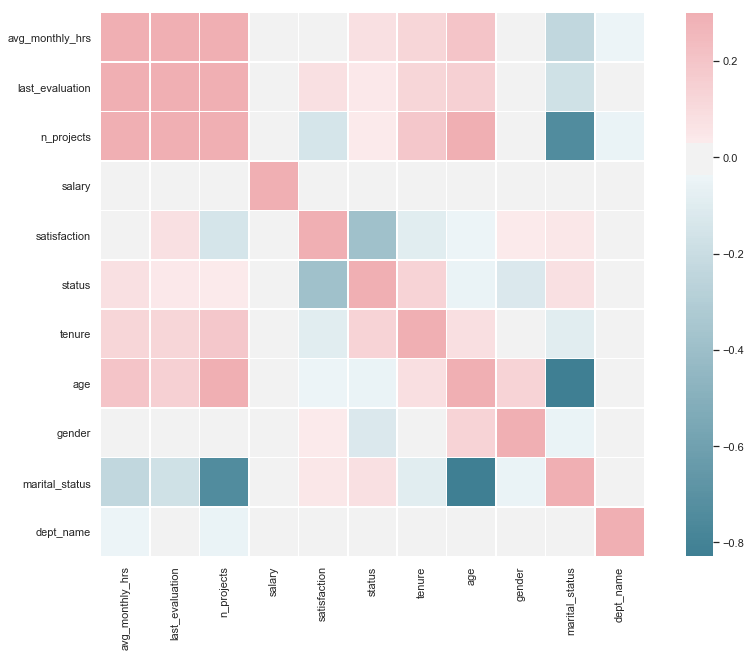

In [117]:
corr = df_copy.corr()
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

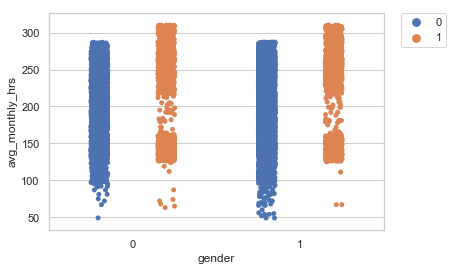

In [118]:
# stripplot
sns.stripplot(x='gender', y='avg_monthly_hrs', data=df_copy, jitter=True, hue='status', dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

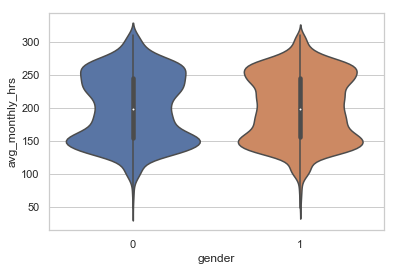

In [119]:
sns.violinplot(x='gender', y='avg_monthly_hrs', data=df_copy)

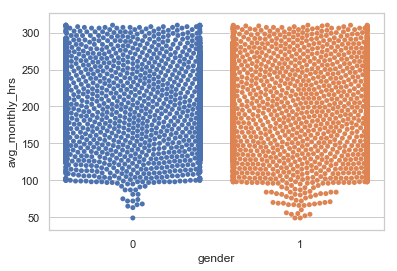

In [120]:
sns.swarmplot(x='gender', y='avg_monthly_hrs', data=df_copy)

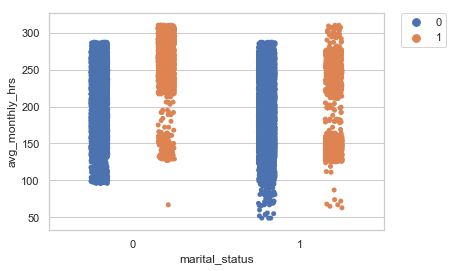

In [121]:
# stripplot
sns.stripplot(x='marital_status', y='avg_monthly_hrs', data=df_copy, jitter=True, hue='status', dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

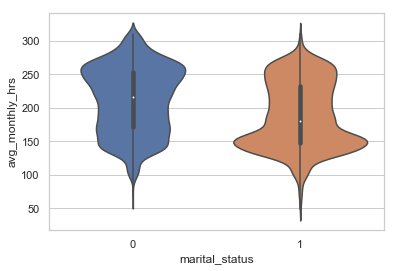

In [122]:
sns.violinplot(x='marital_status', y='avg_monthly_hrs', data=df_copy)

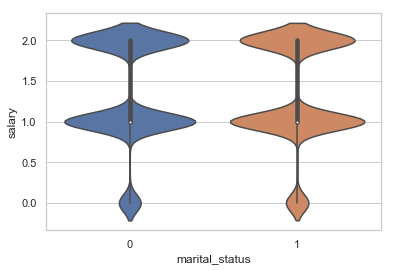

In [123]:
sns.violinplot(x='marital_status', y='salary', data=df_copy)

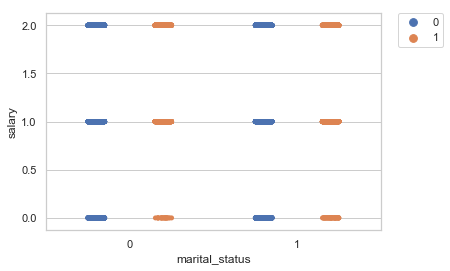

In [124]:
# stripplot
sns.stripplot(x='marital_status', y='salary', data=df_copy, jitter=True, hue='status', dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

<a id = section5></a>

# 5. Machine Learning Models

Since this is a classification problem, we would build the below models and compare them for efficiency.
1. Logistic Regression
2. Naive Bayes
3. SVM
4. Random Forest
5. KNN
    

<a id = section501></a>

## a. Build Models

<a id = section502></a>

## b. Declare hyper-parameters to tune the models

<a id = section503></a>

## c. Fit and tune models with cross-validation

<a id = section504></a>

## d. Evaluate models and finalize the model

<a id = section6></a>

# 6. Predicting the unkown

<a id = section601></a>

## a. Format the unseen data as per our model

<a id = section602></a>

## b. Run the model through the given data

<a id = section603></a>

## c. Publishing the results